###Imports

In [1]:
import gdown
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [2]:
!pip install -q mediapipe==0.10.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 10.2 MB/s eta 0:00:00


In [3]:
!wget -O embedder.tflite -q https://storage.googleapis.com/mediapipe-models/image_embedder/mobilenet_v3_small/float32/1/mobilenet_v3_small.tflite

In [4]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from tqdm import tqdm
from glob import glob

In [5]:
import gc

In [ ]:
!pip install imgaug

In [ ]:
import cv2
from PIL import Image
import imgaug as ia
import imgaug.augmenters as iaa
import random
from scipy.spatial.distance import pdist

###Data preparation

In [ ]:
url = "https://drive.google.com/file/d/10iRg8rA764Sgm_JScEB6zKalpr8x8xKL/view?usp=share_link"
output = "dataset.zip"
gdown.download(url=url, output=output, quiet=True, fuzzy=True)

'dataset.zip'

In [ ]:
!unzip dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: dataset/test/527190_0_0.jpg  
  inflating: dataset/test/527110_37_8.jpg  
  inflating: dataset/test/527301_84_2.jpg  
  inflating: dataset/test/531595_8_4.jpg  
  inflating: dataset/test/527275_24_0.jpg  
  inflating: dataset/test/527215_19_6.jpg  
  inflating: dataset/test/527218_71_1.jpg  
  inflating: dataset/test/527515_65_1.jpg  
  inflating: dataset/test/560741_2_3.jpg  
  inflating: dataset/test/527497_13_0.jpg  
  inflating: dataset/test/531170_16_1.jpg  
  inflating: dataset/test/527193_80_12.jpg  
  inflating: dataset/test/531586_29_1.jpg  
  inflating: dataset/test/546126_50_0.jpg  
  inflating: dataset/test/554317_23_0.jpg  
  inflating: dataset/test/531589_8_1.jpg  
  inflating: dataset/test/545619_81_0.jpg  
  inflating: dataset/test/527139_12_3.jpg  
  inflating: dataset/test/543728_28_2.jpg  
  inflating: dataset/test/554447_67_2.jpg  
  inflating: dataset/test/531287_19_11.jpg  
  inflatin

In [ ]:
!rm dataset/train/554443_24_1.jpg

In [ ]:
def prepare_mobile_net_embeddings_aug(source_path, seq, aug_number = 8):
    # Create options for Image Embedder
    base_options = python.BaseOptions(model_asset_path='embedder.tflite')
    l2_normalize = True
    quantize = False
    options = vision.ImageEmbedderOptions(
      base_options=base_options, l2_normalize=l2_normalize, quantize=quantize)

    images = []
    with vision.ImageEmbedder.create_from_options(options) as embedder:
        for image in tqdm(glob(f'{source_path}/*.jpg')):
            im = load_image(image).squeeze()
            images_np = np.array(
            [im for _ in range(aug_number)],
            dtype=np.uint8
            )
            images_aug = seq(images=images_np)
            emb = np.zeros(1024,)
            for img in images_aug:
                img_for_mp = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)
                #with vision.ImageEmbedder.create_from_options(options) as embedder:
                    #first_image = mp.Image.create_from_file(image)
                    # Format images for MediaPipe
                first_embedding_result = embedder.embed(img_for_mp)
                emb += first_embedding_result.embeddings[0].embedding
            emb /= aug_number
            image_sample = {}
            splitted_path = image.split("/")[-1]
            image_sample["Id"] = splitted_path[-1].split(".")[0]
            image_sample["label"] = splitted_path.split("_")[1]
            emb = emb.tolist()
            for i  in range(len(emb)):
                image_sample[f"embedding_{i}"] = emb[i]
            images.append(image_sample)
    return images

In [ ]:
def prepare_mobile_net_embeddings(source_path):
    # Create options for Image Embedder
    base_options = python.BaseOptions(model_asset_path='embedder.tflite')
    l2_normalize = True
    quantize = False
    options = vision.ImageEmbedderOptions(
      base_options=base_options, l2_normalize=l2_normalize, quantize=quantize)

    images = []
    with vision.ImageEmbedder.create_from_options(options) as embedder:
        for image in tqdm(glob(f'{source_path}/*.jpg', recursive=True)):
            first_image = mp.Image.create_from_file(image)
                    # Format images for MediaPipe
            first_embedding_result = embedder.embed(first_image)

            image_sample = {}
            splitted_path = image.split("/")[-1]
            image_sample["Id"] = splitted_path
            image_sample["label"] = splitted_path.split("_")[1]
            emb = first_embedding_result.embeddings[0].embedding.tolist()
            for i  in range(len(emb)):
                image_sample[f"embedding_{i}"] = emb[i]
            images.append(image_sample)
    return images

In [ ]:
train_data = prepare_mobile_net_embeddings("dataset/train")
test_data = prepare_mobile_net_embeddings("dataset/test")

100%|██████████| 13112/13112 [01:46<00:00, 123.28it/s]


In [ ]:
#test = prepare_mobile_net_embeddings_aug("dataset/test")

In [ ]:
test_df= pd.DataFrame(test_data)
test_df.to_csv("test.csv")
train_df= pd.DataFrame(train_data)
train_df.to_csv("train.csv")

In [ ]:
#test = prepare_mobile_net_embeddings("dataset/test")

In [ ]:
#test_df= pd.DataFrame(test)
#test_df.to_csv("test.csv")

In [ ]:
#df_mobile = pd.DataFrame(full_data)

In [ ]:
#Save temp data
#df_mobile.to_csv("full_dataset.csv")

###Model score on all classes

In [ ]:
df_train = pd.read_csv("augtrain.csv")
df_test = pd.read_csv("test.csv")

In [ ]:
y_train = df_train["label"]
y_test = df_test["label"]
X_train = df_train.loc[:, 'embedding_0':'embedding_1023']
X_test = df_test.loc[:, 'embedding_0':'embedding_1023']

In [ ]:
df_mobile = pd.read_csv("full_dataset.csv")

In [ ]:
labels = train_df["label"]
features = train_df.loc[:, 'embedding_0':'embedding_1023']

X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.8)

In [ ]:
df_mobile.iloc[X_train.index]

,Id,label,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,embedding_7,...,embedding_1014,embedding_1015,embedding_1016,embedding_1017,embedding_1018,embedding_1019,embedding_1020,embedding_1021,embedding_1022,embedding_1023
28131,548705_38_2.jpg,38,-0.012029,0.104217,0.029975,-0.021512,-0.020097,-0.008218,0.006240,0.014761,...,0.026563,-0.017293,-0.020299,0.010957,-0.014763,-0.017269,0.003694,0.024260,0.005432,-0.021944
56908,990387_5_4.jpg,5,-0.020970,-0.022224,-0.019129,0.051613,0.042779,0.034858,-0.001951,-0.016118,...,-0.017814,-0.017440,-0.010403,0.100441,-0.022320,-0.017953,0.060919,-0.016077,-0.012468,0.002809
50,925900_64_1.jpg,64,-0.000000,0.020402,-0.021275,0.037060,0.064100,0.015679,0.059839,0.011000,...,0.012415,-0.020880,-0.019902,-0.021969,0.138778,0.038975,-0.020880,-0.017718,0.033755,0.022556
31854,543782_140_1.jpg,140,-0.015656,0.037791,-0.016535,0.010790,0.019830,0.031666,-0.006651,-0.021959,...,0.008800,0.011777,-0.021204,-0.012818,0.000060,0.024241,0.034258,-0.002623,0.053083,-0.004709
63742,527112_51_0.jpg,51,-0.020584,-0.020154,-0.017017,-0.002812,0.034729,0.008098,-0.008426,0.041357,...,-0.020450,-0.014228,-0.000000,-0.001821,0.087114,-0.015972,-0.015900,-0.016623,-0.019290,-0.018268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21782,527502_10_0.jpg,10,-0.025555,-0.024365,-0.016452,-0.015915,-0.024266,-0.023622,0.015012,-0.020115,...,-0.024541,-0.006721,-0.021404,-0.013915,-0.011471,-0.021720,0.036517,-0.016599,0.020851,0.048745
55220,926190_119_0.jpg,119,-0.024711,0.009119,0.006889,0.002936,0.020643,0.003552,-0.004229,-0.023176,...,0.006906,-0.014948,-0.006322,0.028631,0.001523,0.029371,-0.021843,-0.008159,-0.013553,0.027282
21240,531090_102_1.jpg,102,-0.020174,0.014026,-0.026234,-0.022854,0.043939,-0.026164,0.012569,-0.025023,...,-0.019629,0.035795,0.006809,0.012152,-0.026384,-0.019835,0.039350,-0.024612,-0.012457,0.028607
42501,554331_8_0.jpg,8,-0.026172,-0.003520,-0.027073,-0.020381,-0.018446,0.036195,0.074142,-0.027112,...,-0.017266,-0.016791,-0.026460,-0.022960,-0.019475,-0.020200,0.049467,-0.016028,-0.022244,0.053657


In [ ]:
params = {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 72, 'metric': 'cosine'}
clf = KNeighborsClassifier(**params)
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.8222239170225747

###Model score on classes with support > 500


In [ ]:
def drop_low_count_classes(df, count_threshold):
    df["count"] = df.groupby(["label"])["Id"].transform("count")
    df = df[df["count"] > count_threshold]
    return df

In [ ]:
def cut_on_support(df_mobile, val=500):
    # Train test split
    df = drop_low_count_classes(df_mobile, val)
    labels = df["label"]
    features = df.loc[:, 'embedding_0':'embedding_1023']

    X_train, X_test, y_train, y_test = train_test_split(features, labels, train_size=0.8)
    params = {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 72, 'metric': 'cosine'}
    clf = KNeighborsClassifier(**params)
    # clf = KNeighborsClassifier()
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    return score

In [ ]:
cut_on_support(df_mobile)

0.8893626829549384

###Augmentation

In [ ]:
!pip install imgaug

In [ ]:
import imgaug as ia
import imgaug.augmenters as iaa

In [ ]:
sometimes = lambda aug: iaa.Sometimes(0.3, aug)

seq = iaa.Sequential(
    [
        #
        # Apply the following augmenters to most images.
        #
        iaa.Fliplr(0.1), # horizontally flip 30% of all images
        iaa.Flipud(0.1), # vertically flip 10% of all images

        # crop some of the images by 0-10% of their height/width
        sometimes(iaa.Crop(percent=(0, 0.1))),

        # Apply affine transformations to some of the images
        # - scale to 80-120% of image height/width (each axis independently)
        # - translate by -20 to +20 relative to height/width (per axis)
        # - rotate by -45 to +45 degrees
        # - shear by -16 to +16 degrees
        # - order: use nearest neighbour or bilinear interpolation (fast)
        # - mode: use any available mode to fill newly created pixels
        #         see API or scikit-image for which modes are available
        # - cval: if the mode is constant, then use a random brightness
        #         for the newly created pixels (e.g. sometimes black,
        #         sometimes white)
        sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
            translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},
            rotate=(-20, 20),
            shear=(-16, 16),
            order=[0, 1],
            cval=(0, 255),
            mode=["edge", "symmetric", "reflect"]
        )),

        #
        # Execute 0 to 5 of the following (less important) augmenters per
        # image. Don't execute all of them, as that would often be way too
        # strong.
        #
        iaa.SomeOf((0, 3),
            [

                # Blur each image with varying strength using
                # gaussian blur (sigma between 0 and 3.0),
                # average/uniform blur (kernel size between 2x2 and 7x7)
                # median blur (kernel size between 3x3 and 11x11).
                iaa.OneOf([
                    iaa.GaussianBlur((0, 3.0)),
                    iaa.AverageBlur(k=(2, 7)),
                    iaa.MedianBlur(k=(3, 11)),
                ]),


                # Add gaussian noise to some images.
                # In 50% of these cases, the noise is randomly sampled per
                # channel and pixel.
                # In the other 50% of all cases it is sampled once per
                # pixel (i.e. brightness change).
                iaa.AdditiveGaussianNoise(
                    loc=0, scale=(0.0, 0.05*255)
                ),

                iaa.MotionBlur(k=15, angle=[-45, 45]),

                # Change brightness of images (50-150% of original value).
                iaa.Multiply((0.8, 1.3), per_channel=0.5),

                # In some images distort local areas with varying strength.
                sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05)))
            ],
            # do all of the above augmentations in random order
            random_order=True
        )
    ],
    # do all of the above augmentations in random order
    random_order=True
)

In [ ]:
from PIL import Image
import numpy as np

def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="uint8" )
    return data

def save_image( npdata, outfilename ) :
    img = Image.fromarray( npdata )
    img.save( outfilename )

In [ ]:
!mkdir train

In [ ]:
im = load_image("/content/content/dataset/test/0/527141_0_1.jpg").squeeze()

In [ ]:
images = np.array(
    [im for _ in range(32)],
    dtype=np.uint8
)

In [ ]:
images_aug = seq(images=images)

In [ ]:
k = 0
for i in images_aug:
  k += 1
  save_image(i, f"train/test_{k}.jpg")

In [ ]:
base_options = python.BaseOptions(model_asset_path='embedder.tflite')
l2_normalize = True
quantize = False
options = vision.ImageEmbedderOptions(base_options=base_options, l2_normalize=l2_normalize, quantize=quantize)

images = np.array(
    [im for _ in range(32)],
    dtype=np.uint8
)
images_aug = seq(images=images)
img = mp.Image(image_format=mp.ImageFormat.SRGB, data=images_aug)
with vision.ImageEmbedder.create_from_options(options) as embedder:
    first_embedding_result = embedder.embed(img)


In [ ]:
first_embedding_result.embeddings[0].embedding.shape

(1024,)

In [ ]:
np.zeros(1024,) + first_embedding_result.embeddings[0].embedding / 8

array([-0.00212715,  0.00231999,  0.00042437, ..., -0.00120172,
        0.0050002 , -0.00168207])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!rsync -r --include='*.jpg'  content/dataset/train/*/*.jpg test/

/bin/bash: line 1: /usr/bin/rsync: Argument list too long


In [ ]:
import shutil

In [ ]:
for i in tqdm(glob("/content/content/dataset/train/**/*.jpg")):
    name = i.split("/")[-1]
    if name in s_test:
        shutil.copyfile(i, f"dataset/test/{name}")
    else:
        shutil.copyfile(i, f"dataset/train/{name}")

100%|██████████| 51562/51562 [01:15<00:00, 682.53it/s]


In [ ]:
df_mobile = pd.read_csv("full_dataset.csv")

In [ ]:
"527098_1_3.jpg" in df_mobile.iloc[X_test.index]["Id"]

False

In [ ]:
s_test = set(train_df.iloc[X_test.index]["Id"].values)

In [ ]:
s_train = set(train_df.iloc[X_train.index]["Id"].values)

In [ ]:
"527098_1_3.jpg" in s_train

False

In [ ]:
!mkdir train

In [ ]:
for i in tqdm(glob("dataset/**/*.jpg")):
    print(i)

0it [00:00, ?it/s]


In [ ]:
SCORE_WITHOUGHT_AUG = 0.8478492983526541
SCORE_WITH_TEST_AUGMENTATED = 0.5803843807199512

In [ ]:
!zip -r dataset.zip dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  adding: dataset/test/527190_0_0.jpg (deflated 1%)
  adding: dataset/test/527110_37_8.jpg (deflated 1%)
  adding: dataset/test/527301_84_2.jpg (deflated 1%)
  adding: dataset/test/531595_8_4.jpg (deflated 1%)
  adding: dataset/test/527275_24_0.jpg (deflated 1%)
  adding: dataset/test/527215_19_6.jpg (deflated 2%)
  adding: dataset/test/527218_71_1.jpg (deflated 3%)
  adding: dataset/test/527515_65_1.jpg (deflated 2%)
  adding: dataset/test/560741_2_3.jpg (deflated 5%)
  adding: dataset/test/527497_13_0.jpg (deflated 1%)
  adding: dataset/test/531170_16_1.jpg (deflated 7%)
  adding: dataset/test/527193_80_12.jpg (deflated 1%)
  adding: dataset/test/531586_29_1.jpg (deflated 2%)
  adding: dataset/test/546126_50_0.jpg (deflated 1%)
  adding: dataset/test/554317_23_0.jpg (deflated 5%)
  adding: dataset/test/531589_8_1.jpg (deflated 1%)
  adding: dataset/test/545619_81_0.jpg (deflated 1%)
  adding: dataset/test/527139_12_3

In [ ]:
!cp dataset.zip /content/drive/MyDrive

^C


In [ ]:
!rm dataset/train/554443_24_1.jpg

###plot Search

In [ ]:
y_train = train_df["label"]
X_train = train_df.loc[:, 'embedding_0':'embedding_1023']
y_test = test_df["label"]
X_test = test_df.loc[:, 'embedding_0':'embedding_1023']


In [ ]:
def get_n_train(X_train, y_train, n):
    y_res = pd.Series()
    X_res = pd.DataFrame()
    for ind in y_train.unique():
        try:
            y_sample = y_train[y_train == ind].sample(n=n)
        except:
            y_sample = y_train[y_train == ind].sample(n=len(y_train[y_train == ind]))
        X_sample = X_train.loc[y_sample.index]
        y_res = pd.concat([y_res,y_sample])
        X_res = pd.concat([X_res,X_sample])
    return X_res, y_res

In [ ]:
scores = {key:0 for key in [2**i + 2 for i in range(11)]}

In [ ]:
scores

{3: 0, 4: 0, 6: 0, 10: 0, 18: 0, 34: 0, 66: 0, 130: 0, 258: 0, 514: 0, 1026: 0}

In [ ]:
erorrs = []
for n in tqdm(scores.keys()):
    stat = []
    for i in range(10):
        X_train_temp, y_train_temp = get_n_train(X_train, y_train, n)
        params = {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 72, 'metric': 'cosine'}
        clf = KNeighborsClassifier(**params)
        clf.fit(X_train_temp, y_train_temp)
        stat.append(clf.score(X_test, y_test))
    scores[n] = np.mean(stat)
    erorrs.append(np.std(stat))

  0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-21-87a8a6354713>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_res = pd.Series()
<ipython-input-21-87a8a6354713>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_res = pd.Series()
<ipython-input-21-87a8a6354713>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_res = pd.Series()
<ipython-input-21-87a8a6354713>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_res = pd.Series()
<ipython-input-21-87a8a6354713>:2: FutureWarning: The default dtype for empty Series will 

KeyboardInterrupt: ignored

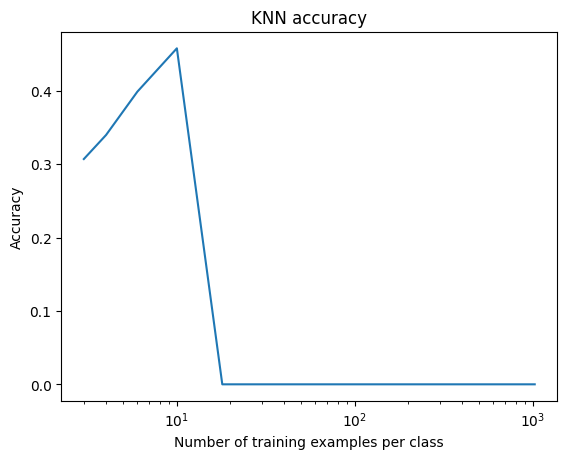

In [ ]:
from matplotlib import pyplot as plt


plt.plot(scores.keys(), scores.values())
plt.xscale('log')
plt.xlabel("Number of training examples per class")
plt.ylabel("Accuracy")
plt.title("KNN accuracy")
plt.show()

In [ ]:
erorrs

[0.008797016325223651,
 0.01117173225788191,
 0.009783205821766613,
 0.005489881894743314]

###AndrewFunction

In [ ]:
def get_n_train(X_train, y_train, n):
    y_res = pd.Series()
    X_res = pd.DataFrame()
    for ind in y_train.unique():
        try:
            y_sample = y_train[y_train == ind].sample(n=n)
        except:
            y_sample = y_train[y_train == ind].sample(n=len(y_train[y_train == ind]))
        X_sample = X_train.loc[y_sample.index]
        y_res = pd.concat([y_res,y_sample])
        X_res = pd.concat([X_res,X_sample])
    return X_res, y_res

In [ ]:
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="uint8" )
    return data

def save_image( npdata, outfilename ) :
    img = Image.fromarray( npdata )
    img.save( outfilename )

In [ ]:
def prepare_mobile_net_embeddings_aug_for_label(image_pathes, seq, label, aug_number = 8, sample_length = 500):
    # Create options for Image Embedder
    base_options = python.BaseOptions(model_asset_path='embedder.tflite')
    l2_normalize = True
    quantize = False
    options = vision.ImageEmbedderOptions(
      base_options=base_options, l2_normalize=l2_normalize, quantize=quantize)

    images = []
    tmp = 0
    with vision.ImageEmbedder.create_from_options(options) as embedder:
        for image in tqdm(image_pathes):
            image_sample = {}
            splitted_path = image.split("/")[-1]
            image_sample["Id"] = splitted_path.split(".")[0]
            image_sample["label"] = splitted_path.split("_")[1]
            if image_sample["label"] == str(label):
                tmp += 1
                im = load_image(image).squeeze()
                images_np = np.array(
                [im for _ in range(aug_number)],
                dtype=np.uint8
                )
                images_aug = seq(images=images_np)
                emb = np.zeros(1024,)
                for img in images_aug:
                    img_for_mp = mp.Image(image_format=mp.ImageFormat.SRGB, data=img)
                    #with vision.ImageEmbedder.create_from_options(options) as embedder:
                        #first_image = mp.Image.create_from_file(image)
                        # Format images for MediaPipe
                    first_embedding_result = embedder.embed(img_for_mp)
                    emb = first_embedding_result.embeddings[0].embedding
                    emb = emb.tolist()
                    for i  in range(len(emb)):
                        image_sample[f"embedding_{i}"] = emb[i]
                    images.append(image_sample)
            if tmp >= sample_length:
                print("Done")
                break
    return images

In [ ]:
def prepare_mobile_net_embeddings_for_label(image_pathes, label):
    # Create options for Image Embedder
    base_options = python.BaseOptions(model_asset_path='embedder.tflite')
    l2_normalize = True
    quantize = False
    options = vision.ImageEmbedderOptions(
      base_options=base_options, l2_normalize=l2_normalize, quantize=quantize)

    images = []
    with vision.ImageEmbedder.create_from_options(options) as embedder:
        for image in tqdm(image_pathes):
            image_sample = {}
            splitted_path = image.split("/")[-1]
            image_sample["Id"] = splitted_path.split(".")[0]
            image_sample["label"] = splitted_path.split("_")[1]
            if image_sample["label"] == str(label):
                first_image = mp.Image.create_from_file(image)
                        # Format images for MediaPipe
                first_embedding_result = embedder.embed(first_image)

                emb = first_embedding_result.embeddings[0].embedding.tolist()
                for i  in range(len(emb)):
                    image_sample[f"embedding_{i}"] = emb[i]
                images.append(image_sample)
    return images

In [ ]:
params = {'horiz_flip_prob': 0.23372002393841368,
          'vert_flip_prob': 0.003580711334931301,
          'crop_prob': 0.020424702330632562,
          'crop_max_value': 0.2552338768996226,
          'affine_scale_x': 0.32408282439318215,
          'affine_scale_y': 0.02278775623930282,
          'affine_translate_x': 0.7341285974850827,
          'affine_translate_y': 0.20893062419459313,
          'affine_rotate': 45,
          'affine_shear': 87,
          'affine_mode': ["symmetric"],
          'max_number_of_strong_aug': 0,
          'gausian_blur_sigma': 0.22334345487784962,
          'average_blur_kernel': 4.742900261926021,
          'motion_blur_kernel': 9,
          'motion_blur_angle': 26,
          'piecewise_affine_scale': 0.031810750909470616}

In [ ]:
def get_augmentator(params):
    sometimes = lambda aug: iaa.Sometimes(params["crop_prob"], aug)

    seq = iaa.Sequential(
        [
            #
            # Apply the following augmenters to most images.
            #
            iaa.Fliplr(params["horiz_flip_prob"]), # horizontally flip 30% of all images
            iaa.Flipud(params["vert_flip_prob"]), # vertically flip 10% of all images

            # crop some of the images by 0-10% of their height/width
            sometimes(iaa.Crop(percent=(0, params["crop_max_value"]))),

            # Apply affine transformations to some of the images
            # - scale to 80-120% of image height/width (each axis independently)
            # - translate by -20 to +20 relative to height/width (per axis)
            # - rotate by -45 to +45 degrees
            # - shear by -16 to +16 degrees
            # - order: use nearest neighbour or bilinear interpolation (fast)
            # - mode: use any available mode to fill newly created pixels
            #         see API or scikit-image for which modes are available
            # - cval: if the mode is constant, then use a random brightness
            #         for the newly created pixels (e.g. sometimes black,
            #         sometimes white)
            sometimes(iaa.Affine(
                scale={"x": (1 - params["affine_scale_x"], 1 + params["affine_scale_x"]),
                       "y": (1 - params["affine_scale_y"], 1 + params["affine_scale_y"])},
                translate_percent={"x": (-params["affine_translate_x"], params["affine_translate_x"]),
                                   "y": (-params["affine_translate_y"], params["affine_translate_y"])},
                rotate=(-params["affine_rotate"], params["affine_rotate"]),
                shear=(-params["affine_shear"], params["affine_shear"]),
                order=[0, 1],
                cval=(0, 255),
                mode=params["affine_mode"]
            )),

            #
            # Execute 0 to 5 of the following (less important) augmenters per
            # image. Don't execute all of them, as that would often be way too
            # strong.
            #
            iaa.SomeOf((0, params["max_number_of_strong_aug"]),
                [

                    # Blur each image with varying strength using
                    # gaussian blur (sigma between 0 and 3.0),
                    # average/uniform blur (kernel size between 2x2 and 7x7)
                    # median blur (kernel size between 3x3 and 11x11).
                    iaa.OneOf([
                        iaa.GaussianBlur(params["gausian_blur_sigma"]),
                        iaa.AverageBlur(k=params["average_blur_kernel"]),
                    ]),


                    # Add gaussian noise to some images.
                    # In 50% of these cases, the noise is randomly sampled per
                    # channel and pixel.
                    # In the other 50% of all cases it is sampled once per
                    # pixel (i.e. brightness change).
                    iaa.AdditiveGaussianNoise(
                        loc=0, scale=(0.0, 0.05*255)
                    ),

                    iaa.MotionBlur(k=params["motion_blur_kernel"], angle=[-params["motion_blur_angle"],
                                                                       params["motion_blur_angle"]]),

                    # Change brightness of images (50-150% of original value).
                    iaa.Multiply((0.8, 1.3), per_channel=0.5),

                    # In some images distort local areas with varying strength.
                    sometimes(iaa.PiecewiseAffine(scale=(params["piecewise_affine_scale"])))
                ],
                # do all of the above augmentations in random order
                random_order=True
            )
        ],
        # do all of the above augmentations in random order
        random_order=True
    )
    return seq

In [ ]:
def AndrewFunction(dataset_path, params, label=0, sample_length=500, aug_number=3):
    image_pathes = glob(f"{dataset_path}/*.jpg")
    random.shuffle(image_pathes)
    seq = get_augmentator(params)
    aug_data = prepare_mobile_net_embeddings_aug_for_label(image_pathes, seq,
                                                           label, aug_number = aug_number,
                                                           sample_length = sample_length)
    random.shuffle(image_pathes)
    data = prepare_mobile_net_embeddings_for_label(image_pathes, label)
    df = pd.DataFrame(data)
    aug_df = pd.DataFrame(aug_data)
    features = df.loc[:, 'embedding_0':'embedding_1023']
    aug_features = aug_df.loc[:, 'embedding_0':'embedding_1023']
    distances = pdist(features, metric="cosine")
    aug_distances = pdist(aug_features, metric="cosine")
    return distances, aug_distances

In [ ]:
def CoolAndrewFunction(dataset_path, params, labels=[0, 1], sample_length=500, aug_number=3):
    image_pathes = glob(f"{dataset_path}/*.jpg")
    random.shuffle(image_pathes)
    seq = get_augmentator(params)
    y_res = pd.Series()
    X_res = pd.DataFrame()
    for label in labels:
        aug_data = prepare_mobile_net_embeddings_aug_for_label(image_pathes, seq,
                                                              label, aug_number = aug_number,
                                                              sample_length = sample_length)
        aug_df = pd.DataFrame(aug_data)
        aug_features = aug_df.loc[:, 'embedding_0':'embedding_1023']
        aug_labels = aug_df["label"]
        y_res = pd.concat([y_res, aug_labels])
        X_res = pd.concat([X_res, aug_features])
    return X_res, y_res

In [ ]:
def get_scores(X_test, y_test, labels, params):
    scores = {key:0 for key in [2**i for i in range(11)]}
    params_1 = {'n_neighbors': 4, 'weights': 'distance', 'leaf_size': 72, 'metric': 'cosine'}
    for n in tqdm(scores.keys()):
        X_train_temp, y_train_temp = CoolAndrewFunction("dataset/train", params, labels=labels, sample_length=n, aug_number=5)
        clf = KNeighborsClassifier(**params_1)
        clf.fit(X_train_temp, y_train_temp)
        scores[n] = clf.score(X_test, y_test)
    return scores

In [ ]:
res, res2 = AndrewFunction("dataset/train", params)

 78%|███████▊  | 31414/40459 [00:36<00:10, 863.34it/s] 


Done


100%|██████████| 40459/40459 [00:06<00:00, 6560.61it/s]


In [ ]:
test_df = pd.read_csv("test.csv")

In [ ]:
X_test = test_df.loc[:, 'embedding_0':'embedding_1023']
y_test = test_df["label"]

In [ ]:
labels = y_test.unique()

In [ ]:
scores = get_scores(X_test, y_test, labels, params)

  0%|          | 0/11 [00:00<?, ?it/s]<ipython-input-16-7a78eb25f837>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_res = pd.Series()

  0%|          | 126/40459 [00:00<00:10, 3861.54it/s]


Done



  0%|          | 65/40459 [00:00<00:22, 1799.68it/s]


Done



  2%|▏         | 745/40459 [00:00<00:01, 22219.86it/s]


Done



  0%|          | 173/40459 [00:00<00:09, 4401.51it/s]


Done



  0%|          | 6/40459 [00:00<03:50, 175.24it/s]


Done



  0%|          | 47/40459 [00:00<00:30, 1327.73it/s]


Done



  0%|          | 45/40459 [00:00<00:44, 912.64it/s]

Done




  0%|          | 0/40459 [00:00<?, ?it/s]

Done




  0%|          | 71/40459 [00:00<00:27, 1467.77it/s]


Done



  0%|          | 86/40459 [00:00<00:22, 1786.34it/s]


Done



  0%|          | 80/40459 [00:00<00:27, 1481.45it/s]


Done



  0%|          | 66/40459 [00:00<00:21, 1848.54it/s]

Done




  2%|▏         | 767/40459 [00:00<00:01, 23635.52it/s]


Done



  0%|          | 58/40459 [00:00<00:22, 1768.58it/s]


Done



  0%|          | 25/40459 [00:00<00:57, 705.91it/s]


Done



  0%|          | 21/40459 [00:00<01:17, 524.32it/s]


Done



  1%|          | 257/40459 [00:00<00:05, 7300.27it/s]


Done



  0%|          | 4/40459 [00:00<05:51, 115.12it/s]


Done



  1%|          | 277/40459 [00:00<00:05, 7697.91it/s]


Done



  0%|          | 2/40459 [00:00<11:48, 57.12it/s]

Done




  0%|          | 5/40459 [00:00<04:54, 137.25it/s]

Done




  6%|▌         | 2524/40459 [00:00<00:00, 63144.10it/s]


Done



  0%|          | 91/40459 [00:00<00:16, 2392.40it/s]


Done



  0%|          | 38/40459 [00:00<00:35, 1141.55it/s]


Done



  0%|          | 1/40459 [00:00<22:00, 30.65it/s]


Done



  0%|          | 26/40459 [00:00<00:56, 711.90it/s]


Done



  0%|          | 35/40459 [00:00<00:35, 1124.58it/s]


Done



  0%|          | 184/40459 [00:00<00:07, 5415.12it/s]


Done



  0%|          | 12/40459 [00:00<02:14, 301.62it/s]


Done



  0%|          | 40/40459 [00:00<00:35, 1124.66it/s]


Done



  0%|          | 22/40459 [00:00<00:59, 675.63it/s]


Done



  0%|          | 102/40459 [00:00<00:14, 2869.82it/s]


Done



  0%|          | 123/40459 [00:00<00:11, 3599.41it/s]


Done



  1%|          | 276/40459 [00:00<00:04, 8130.04it/s]


Done



  1%|          | 218/40459 [00:00<00:06, 6246.00it/s]


Done



  1%|          | 472/40459 [00:00<00:02, 15061.94it/s]


Done



  0%|          | 41/40459 [00:00<00:34, 1188.33it/s]


Done



  0%|          | 7/40459 [00:00<04:07, 163.24it/s]


Done



  0%|          | 75/40459 [00:00<00:16, 2406.44it/s]


Done



  0%|          | 117/40459 [00:00<00:12, 3124.66it/s]


Done



  0%|          | 61/40459 [00:00<00:22, 1829.86it/s]


Done



  0%|          | 8/40459 [00:00<03:08, 214.92it/s]


Done



  1%|          | 413/40459 [00:00<00:03, 11697.74it/s]


Done



  0%|          | 133/40459 [00:00<00:10, 3881.64it/s]


Done



  0%|          | 149/40459 [00:00<00:10, 3718.91it/s]


Done



  1%|          | 231/40459 [00:00<00:06, 6556.17it/s]


Done



  2%|▏         | 710/40459 [00:00<00:01, 20463.67it/s]


Done



  0%|          | 116/40459 [00:00<00:11, 3642.82it/s]


Done



  1%|          | 260/40459 [00:00<00:05, 7659.43it/s]


Done



  1%|          | 235/40459 [00:00<00:05, 6986.94it/s]


Done



  0%|          | 166/40459 [00:00<00:08, 4925.99it/s]


Done



  1%|          | 327/40459 [00:00<00:04, 9576.24it/s]


Done



  0%|          | 29/40459 [00:00<00:51, 785.68it/s]


Done



  0%|          | 67/40459 [00:00<00:22, 1804.22it/s]


Done



  3%|▎         | 1120/40459 [00:00<00:01, 26308.51it/s]


Done



  0%|          | 19/40459 [00:00<01:16, 528.92it/s]


Done



  0%|          | 52/40459 [00:00<00:27, 1477.75it/s]


Done



  0%|          | 43/40459 [00:00<00:29, 1389.37it/s]


Done



  0%|          | 32/40459 [00:00<00:45, 883.83it/s]


Done



  1%|▏         | 525/40459 [00:00<00:02, 14384.32it/s]


Done



  1%|▏         | 602/40459 [00:00<00:02, 17235.77it/s]


Done



  0%|          | 131/40459 [00:00<00:10, 3712.73it/s]


Done



  0%|          | 104/40459 [00:00<00:12, 3111.08it/s]


Done



  0%|          | 48/40459 [00:00<00:29, 1379.63it/s]


Done



  0%|          | 9/40459 [00:00<02:23, 282.84it/s]


Done



  0%|          | 95/40459 [00:00<00:16, 2517.43it/s]


Done



  0%|          | 60/40459 [00:00<00:23, 1736.36it/s]


Done



  0%|          | 185/40459 [00:00<00:08, 4989.88it/s]


Done



  0%|          | 99/40459 [00:00<00:14, 2827.64it/s]


Done



  2%|▏         | 754/40459 [00:00<00:01, 21383.30it/s]


Done



  0%|          | 46/40459 [00:00<00:27, 1484.80it/s]


Done



  1%|          | 253/40459 [00:00<00:06, 6167.91it/s]


Done



  0%|          | 114/40459 [00:00<00:11, 3609.39it/s]


Done



  0%|          | 112/40459 [00:00<00:12, 3129.08it/s]


Done



  1%|          | 206/40459 [00:00<00:06, 6034.76it/s]


Done



  0%|          | 15/40459 [00:00<01:32, 435.54it/s]


Done



  1%|          | 203/40459 [00:00<00:07, 5447.85it/s]


Done



  0%|          | 93/40459 [00:00<00:15, 2584.91it/s]


Done



  1%|          | 418/40459 [00:00<00:03, 11457.23it/s]


Done



  0%|          | 79/40459 [00:00<00:17, 2359.62it/s]


Done



  0%|          | 157/40459 [00:00<00:08, 4825.31it/s]


Done



  0%|          | 10/40459 [00:00<02:32, 264.80it/s]


Done



  0%|          | 97/40459 [00:00<00:14, 2861.15it/s]


Done



  0%|          | 16/40459 [00:00<01:35, 425.11it/s]


Done



  0%|          | 51/40459 [00:00<00:27, 1469.81it/s]


Done



  1%|          | 230/40459 [00:00<00:06, 6128.17it/s]


Done



  0%|          | 193/40459 [00:00<00:06, 5787.40it/s]


Done



  0%|          | 83/40459 [00:00<00:15, 2635.61it/s]


Done



  0%|          | 23/40459 [00:00<01:05, 620.41it/s]


Done



  0%|          | 36/40459 [00:00<00:42, 944.71it/s]


Done



  5%|▍         | 1989/40459 [00:00<00:00, 47651.93it/s]


Done



  1%|          | 460/40459 [00:00<00:03, 12023.61it/s]


Done



  0%|          | 3/40459 [00:00<08:15, 81.72it/s]


Done



  0%|          | 69/40459 [00:00<00:21, 1838.71it/s]


Done



  1%|          | 409/40459 [00:00<00:03, 10408.27it/s]

Done




  0%|          | 18/40459 [00:00<01:10, 575.78it/s]

Done




  0%|          | 118/40459 [00:00<00:13, 3074.89it/s]


Done



  1%|          | 222/40459 [00:00<00:06, 6603.24it/s]


Done



  1%|          | 288/40459 [00:00<00:05, 7894.70it/s]


Done



  0%|          | 106/40459 [00:00<00:13, 3026.40it/s]


Done



  0%|          | 115/40459 [00:00<00:12, 3260.30it/s]


Done



  1%|          | 241/40459 [00:00<00:06, 6547.32it/s]


Done



  2%|▏         | 624/40459 [00:00<00:02, 16464.50it/s]


Done



  1%|          | 445/40459 [00:00<00:03, 12813.59it/s]


Done



  2%|▏         | 639/40459 [00:00<00:02, 18674.34it/s]


Done



  0%|          | 54/40459 [00:00<00:26, 1511.46it/s]


Done



  1%|▏         | 530/40459 [00:00<00:02, 13639.18it/s]


Done



  1%|          | 501/40459 [00:00<00:02, 13473.19it/s]


Done



  0%|          | 113/40459 [00:00<00:14, 2757.98it/s]


Done



  0%|          | 27/40459 [00:00<00:56, 721.91it/s]


Done



  3%|▎         | 1117/40459 [00:00<00:01, 28902.14it/s]


Done



  0%|          | 72/40459 [00:00<00:20, 2008.61it/s]


Done



  3%|▎         | 1237/40459 [00:00<00:01, 33019.50it/s]


Done



  0%|          | 50/40459 [00:00<00:45, 893.62it/s]

Done




  0%|          | 161/40459 [00:00<00:14, 2839.57it/s]


Done



  2%|▏         | 1009/40459 [00:00<00:02, 16120.26it/s]


Done



  0%|          | 44/40459 [00:00<00:53, 760.63it/s]


Done



  2%|▏         | 713/40459 [00:00<00:03, 13073.74it/s]


Done



  5%|▍         | 1913/40459 [00:00<00:01, 28232.89it/s]


Done



  1%|          | 283/40459 [00:00<00:07, 5027.91it/s]


Done



  0%|          | 14/40459 [00:00<02:52, 233.93it/s]


Done



  0%|          | 105/40459 [00:00<00:21, 1897.45it/s]


Done



  0%|          | 170/40459 [00:00<00:11, 3447.70it/s]


Done



  1%|          | 271/40459 [00:00<00:12, 3314.17it/s]


Done



  1%|          | 330/40459 [00:00<00:06, 6039.34it/s]


Done



  1%|          | 389/40459 [00:00<00:05, 7069.90it/s]


Done



  1%|          | 340/40459 [00:00<00:07, 5636.01it/s]


Done



  0%|          | 167/40459 [00:00<00:13, 2953.60it/s]


Done



  5%|▌         | 2063/40459 [00:00<00:01, 37572.73it/s]


Done



  5%|▍         | 1988/40459 [00:00<00:01, 37136.58it/s]


Done



  2%|▏         | 669/40459 [00:00<00:04, 8782.44it/s]


Done



 25%|██▌       | 10311/40459 [00:00<00:00, 123589.62it/s]


Done



  1%|          | 357/40459 [00:00<00:08, 4730.13it/s]


Done



  0%|          | 33/40459 [00:00<01:00, 670.91it/s]


Done



  2%|▏         | 665/40459 [00:00<00:03, 11733.08it/s]


Done



 14%|█▍        | 5727/40459 [00:00<00:00, 68908.20it/s]


Done



  3%|▎         | 1049/40459 [00:00<00:02, 16834.80it/s]


Done



  2%|▏         | 969/40459 [00:00<00:02, 15780.37it/s]


Done



  1%|          | 378/40459 [00:00<00:05, 6717.82it/s]


Done



  0%|          | 103/40459 [00:00<00:20, 1984.54it/s]


Done



  2%|▏         | 858/40459 [00:00<00:02, 15025.75it/s]


Done



  2%|▏         | 618/40459 [00:00<00:03, 11481.57it/s]


Done



  9%|▉         | 3613/40459 [00:00<00:00, 53015.19it/s]


Done



  0%|          | 39/40459 [00:00<00:51, 778.34it/s]


Done



  1%|          | 343/40459 [00:00<00:06, 6025.36it/s]


Done



  4%|▎         | 1507/40459 [00:00<00:01, 25683.93it/s]


Done



  2%|▏         | 913/40459 [00:00<00:02, 16022.39it/s]


Done



  1%|          | 229/40459 [00:00<00:10, 4011.73it/s]


Done



  1%|          | 204/40459 [00:00<00:10, 4009.12it/s]


Done



  0%|          | 24/40459 [00:00<01:27, 463.59it/s]


Done



 11%|█         | 4456/40459 [00:00<00:00, 66745.78it/s]


Done



  0%|          | 78/40459 [00:00<00:18, 2183.67it/s]


Done



 18%|█▊        | 7455/40459 [00:00<00:00, 140692.73it/s]

Done




  2%|▏         | 797/40459 [00:00<00:02, 19670.25it/s]

Done




  1%|          | 306/40459 [00:00<00:04, 8428.60it/s]

Done



  9%|▉         | 1/11 [00:15<02:30, 15.01s/it]<ipython-input-16-7a78eb25f837>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_res = pd.Series()

  1%|          | 295/40459 [00:00<00:08, 4739.09it/s]


Done



  1%|          | 244/40459 [00:00<00:13, 3085.29it/s]


Done



 18%|█▊        | 7199/40459 [00:00<00:00, 90286.53it/s]


Done



  2%|▏         | 611/40459 [00:00<00:04, 8649.54it/s]


Done



  0%|          | 111/40459 [00:00<00:22, 1812.96it/s]


Done



  0%|          | 46/40459 [00:00<00:57, 703.63it/s]


Done



  0%|          | 17/40459 [00:00<02:42, 249.23it/s]


Done



  1%|          | 431/40459 [00:00<00:06, 6560.24it/s]


Done



  1%|          | 365/40459 [00:00<00:07, 5409.10it/s]


Done



  1%|          | 388/40459 [00:00<00:10, 3956.19it/s]


Done



  0%|          | 146/40459 [00:00<00:31, 1261.14it/s]

Done




  0%|          | 23/40459 [00:00<03:18, 203.74it/s]

Done




  2%|▏         | 613/40459 [00:00<00:06, 6616.20it/s]


Done



  1%|          | 471/40459 [00:00<00:06, 6250.88it/s]


Done



  0%|          | 33/40459 [00:00<01:34, 426.98it/s]


Done



  1%|          | 236/40459 [00:00<00:11, 3630.15it/s]


Done



  0%|          | 108/40459 [00:00<00:29, 1369.64it/s]


Done



  0%|          | 145/40459 [00:00<00:20, 1936.58it/s]


Done



  0%|          | 90/40459 [00:00<00:28, 1414.65it/s]


Done



  1%|          | 316/40459 [00:00<00:08, 4752.53it/s]


Done



  0%|          | 103/40459 [00:00<00:25, 1584.14it/s]


Done



 16%|█▌        | 6513/40459 [00:00<00:00, 71641.75it/s]

Done




  0%|          | 187/40459 [00:00<00:14, 2780.63it/s]


Done



  1%|          | 408/40459 [00:00<00:06, 5845.66it/s]


Done



  0%|          | 58/40459 [00:00<00:53, 750.30it/s]


Done



  1%|          | 210/40459 [00:00<00:18, 2169.06it/s]

Done




  0%|          | 87/40459 [00:00<00:46, 870.62it/s]

Done




  2%|▏         | 693/40459 [00:00<00:04, 9056.23it/s]


Done



  1%|          | 343/40459 [00:00<00:08, 4743.55it/s]


Done



  0%|          | 184/40459 [00:00<00:20, 1997.57it/s]


Done



  1%|          | 262/40459 [00:00<00:13, 3069.69it/s]


Done



  0%|          | 27/40459 [00:00<01:37, 412.85it/s]


Done



  0%|          | 169/40459 [00:00<00:16, 2489.69it/s]


Done



  0%|          | 36/40459 [00:00<01:16, 527.20it/s]


Done



  1%|          | 337/40459 [00:00<00:08, 4938.84it/s]


Done



  0%|          | 128/40459 [00:00<00:20, 1960.57it/s]


Done



  1%|          | 268/40459 [00:00<00:11, 3610.10it/s]


Done



  0%|          | 143/40459 [00:00<00:19, 2103.91it/s]


Done



  0%|          | 50/40459 [00:00<00:54, 747.59it/s]


Done



  0%|          | 161/40459 [00:00<00:19, 2096.07it/s]


Done



  0%|          | 57/40459 [00:00<00:54, 741.50it/s]


Done



  1%|          | 441/40459 [00:00<00:07, 5529.25it/s]


Done



  0%|          | 194/40459 [00:00<00:13, 3090.44it/s]


Done



  1%|          | 283/40459 [00:00<00:10, 3999.41it/s]


Done



  1%|          | 209/40459 [00:00<00:14, 2741.28it/s]


Done



  0%|          | 12/40459 [00:00<04:04, 165.75it/s]


Done



  2%|▏         | 933/40459 [00:00<00:03, 10748.51it/s]


Done



  1%|          | 421/40459 [00:00<00:07, 5605.63it/s]


Done



  0%|          | 172/40459 [00:00<00:16, 2407.16it/s]


Done



  1%|          | 261/40459 [00:00<00:10, 3675.36it/s]


Done



  3%|▎         | 1081/40459 [00:00<00:02, 15734.19it/s]


Done



  2%|▏         | 739/40459 [00:00<00:04, 9129.82it/s]


Done



  1%|          | 352/40459 [00:00<00:08, 4985.16it/s]


Done



  0%|          | 28/40459 [00:00<01:48, 373.42it/s]


Done



  2%|▏         | 918/40459 [00:00<00:03, 10139.15it/s]


Done



  2%|▏         | 719/40459 [00:00<00:04, 9590.41it/s]


Done



  3%|▎         | 1092/40459 [00:00<00:02, 13995.88it/s]


Done



  1%|          | 216/40459 [00:00<00:12, 3311.84it/s]


Done



  0%|          | 136/40459 [00:00<00:19, 2118.89it/s]


Done



  1%|          | 375/40459 [00:00<00:07, 5682.70it/s]


Done



  0%|          | 113/40459 [00:00<00:22, 1831.27it/s]


Done



  0%|          | 100/40459 [00:00<00:37, 1063.91it/s]


Done



  1%|          | 470/40459 [00:00<00:05, 6781.55it/s]


Done



  0%|          | 116/40459 [00:00<00:28, 1392.79it/s]


Done



  1%|          | 292/40459 [00:00<00:11, 3408.39it/s]


Done



  0%|          | 32/40459 [00:00<03:42, 181.91it/s]


Done



  1%|          | 254/40459 [00:00<00:24, 1665.18it/s]


Done



  0%|          | 156/40459 [00:00<00:46, 863.95it/s]


Done



  0%|          | 159/40459 [00:00<00:38, 1052.39it/s]


Done



  0%|          | 93/40459 [00:00<01:01, 656.51it/s]


Done



  0%|          | 120/40459 [00:00<00:52, 769.21it/s]


Done



  0%|          | 163/40459 [00:00<00:30, 1307.51it/s]


Done



  1%|          | 211/40459 [00:00<00:29, 1360.90it/s]


Done



  0%|          | 102/40459 [00:00<01:16, 524.48it/s]


Done



  0%|          | 162/40459 [00:00<00:57, 703.07it/s]


Done



  0%|          | 74/40459 [00:00<01:30, 447.31it/s]


Done



  2%|▏         | 864/40459 [00:00<00:07, 5396.20it/s]


Done



  2%|▏         | 691/40459 [00:00<00:14, 2744.08it/s]


Done



  1%|          | 270/40459 [00:00<00:25, 1599.72it/s]


Done



  0%|          | 157/40459 [00:00<00:34, 1154.99it/s]


Done



  1%|▏         | 591/40459 [00:00<00:12, 3270.91it/s]


Done



  0%|          | 165/40459 [00:00<00:33, 1203.12it/s]


Done



  0%|          | 122/40459 [00:00<00:43, 920.73it/s]

Done




  1%|          | 204/40459 [00:00<00:40, 992.38it/s] 


Done



  0%|          | 118/40459 [00:00<00:39, 1031.79it/s]

Done




  1%|▏         | 602/40459 [00:00<00:07, 5589.11it/s]


Done



  1%|          | 228/40459 [00:00<00:27, 1487.95it/s]


Done



  1%|          | 266/40459 [00:00<00:18, 2123.42it/s]


Done



  0%|          | 78/40459 [00:00<00:52, 771.95it/s]


Done



  0%|          | 51/40459 [00:00<01:48, 371.48it/s]


Done



  5%|▌         | 2093/40459 [00:00<00:02, 17258.17it/s]

Done




  7%|▋         | 2676/40459 [00:00<00:02, 16035.69it/s]


Done



  1%|▏         | 592/40459 [00:00<00:08, 4691.77it/s]


Done



  0%|          | 149/40459 [00:00<00:33, 1215.02it/s]


Done



  1%|          | 372/40459 [00:00<00:18, 2182.90it/s]


Done



  0%|          | 66/40459 [00:00<01:22, 490.20it/s]


Done



  0%|          | 83/40459 [00:00<01:06, 609.20it/s]


Done



  1%|          | 280/40459 [00:00<00:21, 1909.15it/s]


Done



  3%|▎         | 1027/40459 [00:00<00:05, 7417.85it/s]


Done



  1%|▏         | 530/40459 [00:00<00:14, 2674.45it/s]


Done



  1%|▏         | 598/40459 [00:00<00:06, 5834.89it/s]


Done



  1%|          | 360/40459 [00:00<00:17, 2256.05it/s]


Done



  5%|▍         | 1827/40459 [00:00<00:02, 14371.89it/s]

Done




  1%|          | 504/40459 [00:00<00:09, 4199.84it/s]


Done



  2%|▏         | 797/40459 [00:00<00:06, 6047.88it/s]


Done



  0%|          | 166/40459 [00:00<00:32, 1257.21it/s]


Done



  1%|▏         | 603/40459 [00:00<00:08, 4441.19it/s]


Done



  3%|▎         | 1174/40459 [00:00<00:04, 9773.11it/s]


Done



  3%|▎         | 1197/40459 [00:00<00:03, 11053.92it/s]


Done



  0%|          | 144/40459 [00:00<00:30, 1314.77it/s]

Done




  1%|▏         | 520/40459 [00:00<00:11, 3601.35it/s]


Done



  1%|          | 415/40459 [00:00<00:10, 3834.02it/s]

Done




  1%|▏         | 584/40459 [00:00<00:08, 4458.57it/s]


Done



  1%|          | 330/40459 [00:00<00:12, 3314.46it/s]

Done




  1%|          | 304/40459 [00:00<00:15, 2664.30it/s]

Done




  4%|▎         | 1506/40459 [00:00<00:02, 14797.46it/s]


Done



 13%|█▎        | 5132/40459 [00:00<00:00, 41518.47it/s]

Done




  4%|▍         | 1768/40459 [00:00<00:03, 9943.35it/s]


Done



  9%|▉         | 3629/40459 [00:00<00:01, 32871.81it/s]


Done



  3%|▎         | 1226/40459 [00:00<00:03, 10516.64it/s]


Done



  0%|          | 148/40459 [00:00<00:56, 714.91it/s]


Done



  3%|▎         | 1131/40459 [00:00<00:05, 7329.58it/s] 


Done



  1%|          | 298/40459 [00:00<00:14, 2786.93it/s]

Done




  2%|▏         | 713/40459 [00:00<00:09, 4102.07it/s]


Done



  1%|          | 207/40459 [00:00<00:30, 1300.73it/s]


Done



  1%|▏         | 557/40459 [00:00<00:16, 2465.97it/s]


Done



  5%|▌         | 2222/40459 [00:00<00:02, 15648.76it/s]


Done



  3%|▎         | 1298/40459 [00:00<00:05, 6885.38it/s]


Done



  3%|▎         | 1318/40459 [00:00<00:04, 8070.77it/s]


Done



  2%|▏         | 695/40459 [00:00<00:08, 4579.09it/s]


Done



  7%|▋         | 2979/40459 [00:00<00:02, 12606.27it/s]


Done



 19%|█▊        | 7549/40459 [00:00<00:01, 30474.45it/s]


Done



  3%|▎         | 1132/40459 [00:00<00:06, 6005.47it/s]


Done



  6%|▌         | 2354/40459 [00:00<00:02, 13010.36it/s]


Done



  4%|▍         | 1809/40459 [00:00<00:04, 8180.54it/s] 


Done



 16%|█▋        | 6637/40459 [00:00<00:01, 25570.23it/s]


Done



  8%|▊         | 3086/40459 [00:00<00:01, 21752.20it/s]


Done



  1%|          | 477/40459 [00:00<00:12, 3274.93it/s]


Done



  0%|          | 193/40459 [00:00<00:35, 1122.52it/s]


Done



  1%|          | 206/40459 [00:00<00:27, 1444.79it/s]


Done



  4%|▍         | 1665/40459 [00:00<00:03, 10180.87it/s]


Done



  6%|▌         | 2261/40459 [00:00<00:02, 15097.27it/s]


Done



 16%|█▌        | 6440/40459 [00:00<00:01, 22693.08it/s]


Done



  0%|          | 137/40459 [00:00<00:48, 833.57it/s]


Done



 11%|█         | 4314/40459 [00:00<00:01, 19982.71it/s]


Done



 12%|█▏        | 4724/40459 [00:00<00:01, 30049.00it/s]


Done



  7%|▋         | 2806/40459 [00:00<00:02, 13349.01it/s]


Done



  3%|▎         | 1047/40459 [00:00<00:04, 8222.59it/s]

Done




 15%|█▌        | 6265/40459 [00:00<00:01, 25155.02it/s]


Done



  3%|▎         | 1101/40459 [00:00<00:05, 7591.62it/s]


Done



  7%|▋         | 2876/40459 [00:00<00:02, 13213.14it/s]


Done



 11%|█         | 4329/40459 [00:00<00:01, 20048.83it/s]


Done



 13%|█▎        | 5239/40459 [00:00<00:01, 28698.58it/s]


Done



  7%|▋         | 2990/40459 [00:00<00:01, 25815.30it/s]


Done



 18%|█▊        | 7130/40459 [00:00<00:00, 57157.96it/s]


Done


 18%|█▊        | 2/11 [00:51<04:07, 27.52s/it]<ipython-input-16-7a78eb25f837>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_res = pd.Series()

  2%|▏         | 763/40459 [00:00<00:13, 2892.41it/s]


Done



  0%|          | 197/40459 [00:00<00:59, 673.43it/s]


Done



 13%|█▎        | 5243/40459 [00:00<00:01, 18518.51it/s]


Done



  1%|          | 340/40459 [00:00<00:36, 1109.31it/s]


Done



  1%|          | 328/40459 [00:00<00:31, 1288.40it/s]


Done



  0%|          | 81/40459 [00:00<02:11, 308.05it/s]


Done



  0%|          | 154/40459 [00:00<02:36, 257.40it/s]

Done




  1%|          | 424/40459 [00:00<00:54, 737.69it/s]


Done



  4%|▎         | 1418/40459 [00:00<00:08, 4363.18it/s]


Done



  1%|▏         | 596/40459 [00:00<00:30, 1304.12it/s]


Done



  1%|▏         | 523/40459 [00:00<00:22, 1791.03it/s]


Done



  1%|          | 269/40459 [00:00<00:42, 947.19it/s] 


Done



  3%|▎         | 1026/40459 [00:00<00:14, 2798.20it/s]


Done



  2%|▏         | 785/40459 [00:00<00:27, 1460.71it/s]


Done



  0%|          | 186/40459 [00:00<01:18, 511.85it/s]


Done



  1%|          | 376/40459 [00:00<00:38, 1050.93it/s]


Done



  1%|          | 354/40459 [00:00<00:25, 1577.94it/s]


Done



  0%|          | 158/40459 [00:00<00:39, 1018.50it/s]


Done



  0%|          | 151/40459 [00:00<00:39, 1009.97it/s]

Done




  1%|          | 305/40459 [00:00<00:20, 1951.13it/s]


Done



  0%|          | 77/40459 [00:00<01:26, 466.13it/s]


Done



 18%|█▊        | 7271/40459 [00:00<00:00, 42697.51it/s]


Done



  3%|▎         | 1098/40459 [00:00<00:05, 7012.51it/s]


Done



  1%|          | 303/40459 [00:00<00:20, 1965.47it/s]


Done



  1%|          | 234/40459 [00:00<00:25, 1560.76it/s]

Done




  2%|▏         | 927/40459 [00:00<00:06, 5760.34it/s]


Done



  0%|          | 112/40459 [00:00<00:56, 716.40it/s]


Done



  2%|▏         | 735/40459 [00:00<00:06, 5910.26it/s]

Done




  1%|          | 248/40459 [00:00<00:26, 1509.05it/s]


Done



  0%|          | 169/40459 [00:00<00:35, 1123.26it/s]

Done




  1%|          | 349/40459 [00:00<00:18, 2213.97it/s]


Done



  1%|          | 337/40459 [00:00<00:18, 2122.70it/s]


Done



  1%|          | 339/40459 [00:00<00:18, 2114.26it/s]


Done



  2%|▏         | 755/40459 [00:00<00:07, 5080.11it/s]


Done



  1%|          | 435/40459 [00:00<00:14, 2842.40it/s]


Done



  2%|▏         | 865/40459 [00:00<00:07, 5165.66it/s]


Done



  1%|          | 399/40459 [00:00<00:15, 2594.91it/s]


Done



  1%|          | 216/40459 [00:00<00:30, 1325.13it/s]


Done



  1%|▏         | 574/40459 [00:00<00:10, 3697.39it/s]


Done



  0%|          | 188/40459 [00:00<00:34, 1162.14it/s]


Done



  1%|          | 204/40459 [00:00<00:32, 1234.51it/s]


Done



  2%|▏         | 900/40459 [00:00<00:07, 5560.65it/s]


Done



  1%|          | 290/40459 [00:00<00:21, 1895.69it/s]


Done



  2%|▏         | 999/40459 [00:00<00:05, 6840.73it/s]


Done



  2%|▏         | 692/40459 [00:00<00:09, 4398.58it/s]


Done



  1%|          | 365/40459 [00:00<00:17, 2314.40it/s]


Done



 10%|▉         | 3886/40459 [00:00<00:01, 24442.43it/s]


Done



  6%|▋         | 2604/40459 [00:00<00:02, 14946.45it/s]


Done



  7%|▋         | 2902/40459 [00:00<00:01, 18822.03it/s]


Done



  1%|          | 355/40459 [00:00<00:17, 2309.00it/s]

Done




  2%|▏         | 747/40459 [00:00<00:08, 4713.22it/s]


Done



  2%|▏         | 928/40459 [00:00<00:05, 6998.60it/s]

Done




  1%|▏         | 581/40459 [00:00<00:10, 3759.71it/s]


Done



  0%|          | 189/40459 [00:00<00:30, 1313.50it/s]


Done



  2%|▏         | 858/40459 [00:00<00:07, 5655.49it/s]


Done



  2%|▏         | 709/40459 [00:00<00:08, 4507.44it/s]


Done



 10%|█         | 4206/40459 [00:00<00:01, 25965.46it/s]


Done



  1%|          | 224/40459 [00:00<00:28, 1433.26it/s]


Done



  1%|          | 226/40459 [00:00<00:27, 1445.34it/s]


Done



  2%|▏         | 848/40459 [00:00<00:07, 5275.37it/s]


Done



  1%|▏         | 524/40459 [00:00<00:12, 3212.06it/s]


Done



  0%|          | 162/40459 [00:00<00:39, 1026.51it/s]


Done



  1%|          | 301/40459 [00:00<00:19, 2023.05it/s]


Done



  6%|▌         | 2514/40459 [00:00<00:02, 14816.28it/s]


Done



  1%|          | 222/40459 [00:00<00:26, 1506.01it/s]


Done



  1%|          | 439/40459 [00:00<00:18, 2108.52it/s]


Done



  1%|          | 284/40459 [00:00<00:31, 1286.39it/s]


Done



  2%|▏         | 844/40459 [00:00<00:09, 4020.11it/s]


Done



  1%|          | 462/40459 [00:00<00:20, 1909.54it/s]


Done



  1%|          | 251/40459 [00:00<00:32, 1248.12it/s]


Done



  2%|▏         | 913/40459 [00:00<00:08, 4863.71it/s]


Done



  1%|▏         | 538/40459 [00:00<00:16, 2473.61it/s]


Done



  1%|          | 405/40459 [00:00<00:20, 1981.34it/s]


Done



  1%|          | 247/40459 [00:00<00:36, 1108.14it/s]


Done



  2%|▏         | 689/40459 [00:00<00:12, 3222.26it/s]


Done



  1%|          | 502/40459 [00:00<00:16, 2354.17it/s]


Done



  1%|          | 422/40459 [00:00<00:18, 2173.38it/s]


Done



  2%|▏         | 700/40459 [00:00<00:13, 3039.00it/s]


Done



  3%|▎         | 1322/40459 [00:00<00:06, 6090.73it/s]


Done



  1%|▏         | 550/40459 [00:00<00:15, 2534.03it/s]


Done



  2%|▏         | 681/40459 [00:00<00:13, 2953.76it/s]


Done



  1%|▏         | 541/40459 [00:00<00:15, 2578.72it/s]


Done



  0%|          | 56/40459 [00:00<02:37, 256.76it/s]


Done



  0%|          | 160/40459 [00:00<00:54, 741.94it/s]


Done



  2%|▏         | 974/40459 [00:00<00:06, 5845.64it/s]


Done



 15%|█▍        | 6053/40459 [00:00<00:00, 34610.65it/s]


Done



  4%|▍         | 1605/40459 [00:00<00:03, 10203.46it/s]


Done



  1%|          | 443/40459 [00:00<00:14, 2744.70it/s]


Done



  2%|▏         | 892/40459 [00:00<00:07, 5176.09it/s]


Done



  1%|          | 259/40459 [00:00<00:24, 1645.54it/s]


Done



  3%|▎         | 1198/40459 [00:00<00:05, 6743.42it/s]


Done



 17%|█▋        | 6750/40459 [00:00<00:00, 41878.08it/s]


Done



  4%|▍         | 1588/40459 [00:00<00:04, 9648.08it/s] 


Done



  2%|▏         | 675/40459 [00:00<00:08, 4499.57it/s]


Done



  8%|▊         | 3281/40459 [00:00<00:01, 20456.07it/s]


Done



  1%|          | 313/40459 [00:00<00:19, 2037.70it/s]


Done



  1%|▏         | 532/40459 [00:00<00:12, 3272.32it/s]


Done



  2%|▏         | 925/40459 [00:00<00:06, 5868.35it/s]


Done



  2%|▏         | 638/40459 [00:00<00:09, 4123.33it/s]


Done



  2%|▏         | 851/40459 [00:00<00:07, 5272.53it/s]


Done



  2%|▏         | 752/40459 [00:00<00:08, 4903.93it/s]


Done



  1%|          | 246/40459 [00:00<00:27, 1470.84it/s]


Done



  6%|▌         | 2500/40459 [00:00<00:02, 14514.87it/s]


Done



  2%|▏         | 608/40459 [00:00<00:08, 4735.15it/s]

Done




  5%|▍         | 2011/40459 [00:00<00:02, 13346.41it/s]


Done



  2%|▏         | 942/40459 [00:00<00:07, 5414.11it/s]


Done



  8%|▊         | 3105/40459 [00:00<00:02, 17523.06it/s]


Done



  4%|▍         | 1780/40459 [00:00<00:03, 10584.21it/s]


Done



  1%|          | 217/40459 [00:00<00:28, 1418.21it/s]


Done



  1%|          | 487/40459 [00:00<00:12, 3147.06it/s]


Done



  1%|▏         | 560/40459 [00:00<00:12, 3266.48it/s]


Done



  1%|          | 372/40459 [00:00<00:16, 2403.41it/s]


Done



  5%|▍         | 1917/40459 [00:00<00:03, 11145.29it/s]


Done



  3%|▎         | 1013/40459 [00:00<00:06, 6499.61it/s]


Done



  1%|          | 319/40459 [00:00<00:21, 1898.54it/s]


Done



 11%|█         | 4418/40459 [00:00<00:01, 26646.70it/s]


Done



 13%|█▎        | 5171/40459 [00:00<00:01, 28862.76it/s]


Done



  9%|▉         | 3705/40459 [00:00<00:01, 22168.34it/s]


Done



 10%|█         | 4212/40459 [00:00<00:01, 25548.51it/s]


Done



  5%|▍         | 2007/40459 [00:00<00:03, 12417.81it/s]


Done



  4%|▍         | 1538/40459 [00:00<00:04, 9391.88it/s]


Done



  3%|▎         | 1218/40459 [00:00<00:05, 7194.85it/s]


Done



  1%|▏         | 552/40459 [00:00<00:11, 3484.75it/s]


Done



  4%|▍         | 1558/40459 [00:00<00:04, 9582.86it/s]


Done



  3%|▎         | 1055/40459 [00:00<00:05, 6702.38it/s]


Done



  7%|▋         | 2691/40459 [00:00<00:02, 16989.88it/s]


Done



 29%|██▊       | 11572/40459 [00:00<00:00, 63997.60it/s]


Done



  1%|          | 447/40459 [00:00<00:13, 3017.84it/s]


Done



  9%|▉         | 3668/40459 [00:00<00:01, 22646.28it/s]


Done



 25%|██▌       | 10185/40459 [00:00<00:00, 57185.25it/s]


Done



 10%|█         | 4123/40459 [00:00<00:01, 18337.08it/s]


Done



100%|██████████| 40459/40459 [00:00<00:00, 133390.36it/s]

  6%|▌         | 2344/40459 [00:00<00:03, 11440.94it/s]


Done



  5%|▌         | 2217/40459 [00:00<00:03, 10999.26it/s]


Done



 14%|█▍        | 5847/40459 [00:00<00:01, 25543.67it/s]


Done



 46%|████▋     | 18757/40459 [00:00<00:00, 53246.61it/s]


Done



  2%|▏         | 809/40459 [00:00<00:10, 3800.26it/s]


Done



  3%|▎         | 1412/40459 [00:00<00:06, 5903.31it/s]


Done



  6%|▋         | 2605/40459 [00:00<00:03, 10544.95it/s]


Done



 14%|█▍        | 5620/40459 [00:00<00:01, 23040.45it/s]


Done



 16%|█▋        | 6671/40459 [00:00<00:01, 28861.31it/s]


Done



 12%|█▏        | 4938/40459 [00:00<00:01, 21610.67it/s]


Done



 19%|█▉        | 7709/40459 [00:00<00:01, 30015.66it/s]


Done



  3%|▎         | 1369/40459 [00:00<00:05, 6815.28it/s] 


Done



 12%|█▏        | 4731/40459 [00:00<00:01, 19232.19it/s]


Done



 14%|█▍        | 5744/40459 [00:00<00:01, 23421.07it/s]


Done



 14%|█▍        | 5757/40459 [00:00<00:01, 27605.62it/s]


Done



 11%|█         | 4383/40459 [00:00<00:01, 25369.16it/s]


Done



 38%|███▊      | 15569/40459 [00:00<00:00, 82725.82it/s]


Done



  3%|▎         | 1139/40459 [00:00<00:05, 7035.12it/s]


Done



  8%|▊         | 3080/40459 [00:00<00:01, 18941.93it/s]


Done



 15%|█▌        | 6163/40459 [00:00<00:00, 36400.20it/s]


Done



 70%|███████   | 28409/40459 [00:00<00:00, 132135.52it/s]


Done



 15%|█▌        | 6146/40459 [00:00<00:00, 37672.10it/s]


Done



 76%|███████▌  | 30661/40459 [00:00<00:00, 140616.53it/s]


Done


 27%|██▋       | 3/11 [01:35<04:42, 35.32s/it]<ipython-input-16-7a78eb25f837>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_res = pd.Series()

  7%|▋         | 2685/40459 [00:00<00:04, 8367.63it/s]


Done



  1%|▏         | 595/40459 [00:00<00:20, 1986.46it/s]


Done



 21%|██        | 8552/40459 [00:00<00:01, 26932.57it/s]


Done



  2%|▏         | 770/40459 [00:00<00:16, 2437.81it/s]


Done



  1%|          | 314/40459 [00:00<00:37, 1075.84it/s]


Done



  1%|          | 461/40459 [00:00<00:24, 1619.25it/s]


Done



  1%|          | 390/40459 [00:00<00:32, 1238.24it/s]


Done



  5%|▌         | 2105/40459 [00:00<00:04, 7832.19it/s] 


Done



  2%|▏         | 994/40459 [00:00<00:12, 3183.96it/s]


Done



  2%|▏         | 645/40459 [00:00<00:18, 2143.88it/s]


Done



  2%|▏         | 715/40459 [00:00<00:17, 2303.07it/s]


Done



  1%|          | 253/40459 [00:00<00:48, 835.14it/s]


Done



  4%|▎         | 1440/40459 [00:00<00:08, 4745.12it/s]


Done



  1%|          | 442/40459 [00:00<00:36, 1086.47it/s]


Done



  1%|          | 363/40459 [00:00<00:47, 835.85it/s]


Done



  3%|▎         | 1168/40459 [00:00<00:13, 2910.38it/s]


Done



  4%|▍         | 1616/40459 [00:00<00:09, 3900.47it/s]


Done



  1%|          | 455/40459 [00:00<00:33, 1179.18it/s]


Done



  1%|          | 460/40459 [00:00<00:33, 1179.88it/s]


Done



  2%|▏         | 728/40459 [00:00<00:23, 1672.75it/s]


Done



  1%|          | 223/40459 [00:00<01:20, 502.43it/s]


Done



 32%|███▏      | 12902/40459 [00:00<00:01, 26351.64it/s]


Done



  3%|▎         | 1143/40459 [00:00<00:15, 2581.24it/s]


Done



  2%|▏         | 655/40459 [00:00<00:28, 1394.80it/s]


Done



  2%|▏         | 834/40459 [00:00<00:13, 2904.40it/s]


Done



  3%|▎         | 1052/40459 [00:00<00:11, 3448.83it/s]


Done



  1%|          | 345/40459 [00:00<00:35, 1134.47it/s]


Done



  2%|▏         | 828/40459 [00:00<00:14, 2701.07it/s]


Done



  1%|▏         | 518/40459 [00:00<00:24, 1619.86it/s]


Done



  2%|▏         | 942/40459 [00:00<00:14, 2801.49it/s]


Done



  1%|          | 429/40459 [00:00<00:29, 1334.64it/s]


Done



  2%|▏         | 719/40459 [00:00<00:16, 2360.57it/s]


Done



  2%|▏         | 638/40459 [00:00<00:19, 2039.72it/s]


Done



  4%|▎         | 1506/40459 [00:00<00:08, 4751.19it/s]


Done



  2%|▏         | 696/40459 [00:00<00:18, 2107.60it/s]


Done



  3%|▎         | 1112/40459 [00:00<00:10, 3640.80it/s]


Done



  2%|▏         | 633/40459 [00:00<00:19, 2084.11it/s]


Done



  2%|▏         | 624/40459 [00:00<00:19, 2002.93it/s]


Done



  2%|▏         | 961/40459 [00:00<00:13, 2931.41it/s]


Done



  2%|▏         | 987/40459 [00:00<00:12, 3123.55it/s]


Done



  1%|          | 282/40459 [00:00<00:43, 929.98it/s]


Done



  1%|▏         | 554/40459 [00:00<00:21, 1823.91it/s]


Done



  3%|▎         | 1355/40459 [00:00<00:08, 4512.84it/s]


Done



 10%|▉         | 3899/40459 [00:00<00:02, 12547.05it/s]


Done



  1%|▏         | 572/40459 [00:00<00:20, 1912.44it/s]


Done



  2%|▏         | 740/40459 [00:00<00:16, 2442.43it/s]


Done



  6%|▌         | 2254/40459 [00:00<00:05, 7382.89it/s]


Done



  6%|▌         | 2495/40459 [00:00<00:04, 8995.94it/s] 


Done



  7%|▋         | 3006/40459 [00:00<00:03, 9741.78it/s] 


Done



  2%|▏         | 621/40459 [00:00<00:20, 1958.52it/s]


Done



  5%|▌         | 2142/40459 [00:00<00:05, 6948.25it/s]


Done



  8%|▊         | 3316/40459 [00:00<00:04, 7759.48it/s]


Done



  2%|▏         | 863/40459 [00:00<00:19, 2008.48it/s]


Done



  3%|▎         | 1077/40459 [00:00<00:16, 2321.08it/s]


Done



  7%|▋         | 2849/40459 [00:00<00:05, 6271.52it/s]


Done



  2%|▏         | 944/40459 [00:00<00:17, 2240.63it/s]


Done



 23%|██▎       | 9471/40459 [00:00<00:01, 19454.15it/s]


Done



  2%|▏         | 713/40459 [00:00<00:24, 1643.43it/s]


Done



  1%|          | 417/40459 [00:00<00:46, 858.70it/s]


Done



  5%|▍         | 2004/40459 [00:00<00:07, 5004.15it/s]


Done



  3%|▎         | 1396/40459 [00:00<00:11, 3508.95it/s]


Done



  3%|▎         | 1031/40459 [00:00<00:12, 3250.19it/s]


Done



  2%|▏         | 934/40459 [00:00<00:13, 3018.62it/s]


Done



  3%|▎         | 1327/40459 [00:00<00:08, 4520.46it/s]


Done



  3%|▎         | 1134/40459 [00:00<00:10, 3708.23it/s]


Done



  1%|▏         | 528/40459 [00:00<00:23, 1676.04it/s]


Done



  2%|▏         | 776/40459 [00:00<00:16, 2450.40it/s]


Done



  3%|▎         | 1079/40459 [00:00<00:10, 3630.27it/s]


Done



  1%|▏         | 605/40459 [00:00<00:19, 2018.04it/s]


Done



  5%|▍         | 1899/40459 [00:00<00:06, 6127.20it/s]


Done



  6%|▌         | 2407/40459 [00:00<00:04, 7808.39it/s]


Done



  5%|▍         | 1920/40459 [00:00<00:06, 6085.06it/s]


Done



  4%|▍         | 1705/40459 [00:00<00:07, 5443.53it/s]


Done



  1%|▏         | 552/40459 [00:00<00:21, 1842.33it/s]


Done



  4%|▎         | 1514/40459 [00:00<00:07, 5206.92it/s]


Done



  1%|▏         | 553/40459 [00:00<00:23, 1734.75it/s]


Done



  6%|▌         | 2485/40459 [00:00<00:04, 7825.16it/s]


Done



  5%|▍         | 2008/40459 [00:00<00:06, 6406.92it/s]


Done



  2%|▏         | 875/40459 [00:00<00:14, 2785.89it/s]


Done



  2%|▏         | 789/40459 [00:00<00:15, 2620.15it/s]


Done



  6%|▌         | 2395/40459 [00:00<00:04, 7778.53it/s] 


Done



  1%|          | 368/40459 [00:00<00:33, 1192.11it/s]


Done



  1%|▏         | 543/40459 [00:00<00:23, 1704.90it/s]


Done



  1%|          | 481/40459 [00:00<00:23, 1724.51it/s]


Done



  5%|▍         | 1866/40459 [00:00<00:06, 6096.70it/s]


Done



 17%|█▋        | 6949/40459 [00:00<00:01, 21609.86it/s]


Done



  4%|▍         | 1677/40459 [00:00<00:07, 5085.59it/s]


Done



  3%|▎         | 1345/40459 [00:00<00:09, 4169.12it/s]


Done



  2%|▏         | 777/40459 [00:00<00:22, 1767.59it/s]


Done



  2%|▏         | 667/40459 [00:00<00:24, 1616.79it/s]


Done



 13%|█▎        | 5425/40459 [00:00<00:02, 13790.08it/s]


Done



 25%|██▍       | 10044/40459 [00:00<00:01, 19814.68it/s]


Done



  5%|▌         | 2082/40459 [00:00<00:08, 4552.27it/s]


Done



  4%|▍         | 1543/40459 [00:00<00:11, 3461.16it/s]


Done



 10%|▉         | 3946/40459 [00:00<00:03, 9879.91it/s] 


Done



  2%|▏         | 1002/40459 [00:00<00:16, 2322.91it/s]


Done



  2%|▏         | 707/40459 [00:00<00:26, 1514.23it/s]


Done



  2%|▏         | 1008/40459 [00:00<00:17, 2294.92it/s]


Done



  9%|▊         | 3461/40459 [00:00<00:03, 9579.23it/s]


Done



  3%|▎         | 1075/40459 [00:00<00:12, 3268.88it/s]


Done



  7%|▋         | 2655/40459 [00:00<00:04, 8304.23it/s]


Done



  1%|▏         | 584/40459 [00:00<00:20, 1909.35it/s]


Done



 18%|█▊        | 7473/40459 [00:00<00:01, 23483.13it/s]


Done



  7%|▋         | 2797/40459 [00:00<00:04, 9154.52it/s]


Done



 10%|█         | 4199/40459 [00:00<00:02, 14030.68it/s]


Done



  3%|▎         | 1195/40459 [00:00<00:10, 3902.08it/s]


Done



  5%|▍         | 1865/40459 [00:00<00:06, 5999.51it/s]


Done



 17%|█▋        | 6905/40459 [00:00<00:01, 20609.34it/s]


Done



  5%|▌         | 2038/40459 [00:00<00:06, 6348.04it/s]


Done



  2%|▏         | 897/40459 [00:00<00:14, 2818.29it/s]


Done



  5%|▍         | 1855/40459 [00:00<00:07, 5401.28it/s]


Done



  2%|▏         | 992/40459 [00:00<00:11, 3488.00it/s]


Done



  9%|▉         | 3746/40459 [00:00<00:02, 12276.15it/s]


Done



  5%|▍         | 1854/40459 [00:00<00:06, 5944.14it/s]


Done



  4%|▍         | 1761/40459 [00:00<00:07, 5501.94it/s]


Done



  7%|▋         | 2714/40459 [00:00<00:04, 8465.79it/s]


Done



 46%|████▌     | 18592/40459 [00:00<00:00, 52933.27it/s]


Done



 14%|█▍        | 5606/40459 [00:00<00:01, 18368.62it/s]


Done



 39%|███▉      | 15959/40459 [00:00<00:00, 46455.63it/s]


Done



 12%|█▏        | 4945/40459 [00:00<00:02, 16213.55it/s]


Done



  5%|▌         | 2132/40459 [00:00<00:05, 6619.29it/s]


Done



  4%|▍         | 1568/40459 [00:00<00:08, 4860.53it/s]


Done



  4%|▎         | 1461/40459 [00:00<00:08, 4668.97it/s]


Done



 14%|█▍        | 5571/40459 [00:00<00:02, 16000.37it/s]


Done



 12%|█▏        | 4789/40459 [00:00<00:02, 12042.60it/s]


Done



  6%|▌         | 2480/40459 [00:00<00:06, 5769.81it/s]


Done



 25%|██▌       | 10160/40459 [00:00<00:01, 20613.45it/s]


Done



  2%|▏         | 945/40459 [00:00<00:16, 2327.72it/s]


Done



 19%|█▊        | 7511/40459 [00:00<00:02, 14746.11it/s]


Done



 39%|███▉      | 15868/40459 [00:00<00:00, 35097.54it/s]


Done



 15%|█▌        | 6165/40459 [00:00<00:02, 14615.83it/s]


Done



100%|██████████| 40459/40459 [00:00<00:00, 115100.08it/s]

 16%|█▌        | 6471/40459 [00:00<00:02, 13012.59it/s]


Done



 10%|▉         | 3861/40459 [00:00<00:04, 8931.09it/s] 


Done



 40%|███▉      | 16169/40459 [00:00<00:00, 33322.88it/s]


Done



 95%|█████████▍| 38365/40459 [00:00<00:00, 65387.85it/s]


Done



 10%|█         | 4060/40459 [00:00<00:02, 12656.97it/s]


Done



  9%|▉         | 3805/40459 [00:00<00:03, 11346.78it/s]


Done



  8%|▊         | 3201/40459 [00:00<00:03, 9841.49it/s] 


Done



 20%|█▉        | 7983/40459 [00:00<00:01, 26205.80it/s]


Done



 29%|██▊       | 11534/40459 [00:00<00:00, 37719.35it/s]


Done



 78%|███████▊  | 31404/40459 [00:00<00:00, 81431.11it/s]


Done



 49%|████▉     | 19833/40459 [00:00<00:00, 50699.61it/s]


Done



 11%|█         | 4468/40459 [00:00<00:03, 9362.30it/s] 

Done




 20%|██        | 8264/40459 [00:00<00:02, 13031.67it/s]


Done



 27%|██▋       | 10958/40459 [00:00<00:00, 31749.59it/s]


Done



 13%|█▎        | 5448/40459 [00:00<00:02, 17255.80it/s]


Done



 28%|██▊       | 11283/40459 [00:00<00:00, 33478.26it/s]


Done



 65%|██████▌   | 26356/40459 [00:00<00:00, 71619.65it/s]


Done



  8%|▊         | 3243/40459 [00:00<00:03, 10359.03it/s]


Done



 25%|██▌       | 10126/40459 [00:00<00:01, 30291.69it/s]


Done



 43%|████▎     | 17238/40459 [00:00<00:00, 49664.15it/s]


Done



100%|██████████| 40459/40459 [00:00<00:00, 114603.38it/s]

 28%|██▊       | 11295/40459 [00:00<00:00, 34621.62it/s]


Done



 36%|███▋      | 4/11 [02:50<05:55, 50.80s/it]<ipython-input-16-7a78eb25f837>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_res = pd.Series()

 20%|█▉        | 8006/40459 [00:00<00:02, 13623.93it/s]


Done



  2%|▏         | 989/40459 [00:00<00:23, 1696.06it/s]


Done



 45%|████▌     | 18240/40459 [00:00<00:00, 29254.65it/s]


Done



  4%|▎         | 1504/40459 [00:00<00:15, 2505.05it/s]


Done



  2%|▏         | 762/40459 [00:00<00:32, 1239.06it/s]


Done



  2%|▏         | 646/40459 [00:00<00:35, 1135.84it/s]


Done



  1%|▏         | 537/40459 [00:00<00:46, 850.46it/s] 


Done



 10%|▉         | 3892/40459 [00:00<00:05, 7005.21it/s]


Done



  7%|▋         | 2906/40459 [00:00<00:07, 5000.01it/s]


Done



  5%|▍         | 1821/40459 [00:00<00:13, 2862.07it/s]


Done



  3%|▎         | 1403/40459 [00:00<00:18, 2155.24it/s]


Done



  1%|          | 383/40459 [00:00<01:28, 452.26it/s]


Done



 10%|█         | 4067/40459 [00:00<00:07, 5114.94it/s]


Done



  6%|▋         | 2556/40459 [00:00<00:11, 3310.88it/s]


Done



  2%|▏         | 883/40459 [00:00<00:42, 932.25it/s]


Done



  4%|▍         | 1588/40459 [00:00<00:20, 1861.87it/s]


Done



  4%|▍         | 1687/40459 [00:00<00:19, 1945.20it/s]


Done



  2%|▏         | 795/40459 [00:00<00:34, 1158.93it/s]


Done



  2%|▏         | 983/40459 [00:00<00:24, 1591.45it/s]


Done



  3%|▎         | 1223/40459 [00:00<00:19, 2060.27it/s]


Done



  2%|▏         | 689/40459 [00:00<00:35, 1121.17it/s]


Done



 94%|█████████▎| 37844/40459 [00:00<00:00, 53401.84it/s]


Done



 10%|▉         | 3935/40459 [00:00<00:05, 6572.52it/s]


Done



  3%|▎         | 1368/40459 [00:00<00:17, 2218.55it/s]


Done



  2%|▏         | 975/40459 [00:00<00:25, 1537.57it/s]


Done



  4%|▍         | 1690/40459 [00:00<00:14, 2643.08it/s]


Done



  1%|          | 464/40459 [00:00<00:52, 761.32it/s]


Done



  6%|▌         | 2515/40459 [00:00<00:08, 4269.04it/s]


Done



  5%|▍         | 1874/40459 [00:00<00:13, 2862.45it/s]


Done



  3%|▎         | 1046/40459 [00:00<00:24, 1641.67it/s]


Done



  3%|▎         | 1172/40459 [00:00<00:20, 1905.43it/s]


Done



  3%|▎         | 1062/40459 [00:00<00:28, 1395.06it/s]


Done



  4%|▎         | 1420/40459 [00:00<00:22, 1739.74it/s]


Done



  5%|▍         | 1829/40459 [00:00<00:17, 2191.96it/s]


Done



  3%|▎         | 1182/40459 [00:00<00:27, 1446.17it/s]


Done



  8%|▊         | 3128/40459 [00:00<00:09, 3830.76it/s]


Done



  6%|▌         | 2345/40459 [00:00<00:14, 2717.97it/s]


Done



  3%|▎         | 1071/40459 [00:00<00:31, 1251.80it/s]


Done



  5%|▍         | 1950/40459 [00:00<00:12, 3189.04it/s]


Done



  5%|▌         | 2213/40459 [00:00<00:10, 3519.84it/s]


Done



  2%|▏         | 622/40459 [00:00<00:39, 996.35it/s] 


Done



  5%|▌         | 2114/40459 [00:00<00:11, 3354.87it/s]


Done



  5%|▍         | 1832/40459 [00:00<00:13, 2833.28it/s]


Done



 12%|█▏        | 4888/40459 [00:00<00:04, 7893.58it/s]


Done



  5%|▌         | 2078/40459 [00:00<00:11, 3252.91it/s]


Done



  3%|▎         | 1050/40459 [00:00<00:23, 1684.69it/s]


Done



 30%|██▉       | 12089/40459 [00:00<00:01, 19344.72it/s]


Done



 20%|█▉        | 7998/40459 [00:00<00:02, 11895.02it/s]


Done



 32%|███▏      | 12911/40459 [00:00<00:01, 20186.79it/s]


Done



  3%|▎         | 1175/40459 [00:00<00:20, 1941.39it/s]


Done



 13%|█▎        | 5120/40459 [00:00<00:04, 7921.89it/s]


Done



 12%|█▏        | 5046/40459 [00:00<00:04, 7779.39it/s] 


Done



  5%|▌         | 2061/40459 [00:00<00:15, 2416.14it/s]


Done



  6%|▌         | 2392/40459 [00:00<00:12, 2953.01it/s]


Done



 13%|█▎        | 5250/40459 [00:00<00:05, 6488.73it/s]


Done



  4%|▍         | 1662/40459 [00:00<00:20, 1849.74it/s]


Done



 43%|████▎     | 17286/40459 [00:00<00:01, 19775.34it/s]


Done



  4%|▍         | 1726/40459 [00:00<00:19, 1965.46it/s]


Done



  2%|▏         | 1000/40459 [00:00<00:28, 1378.93it/s]


Done



 13%|█▎        | 5422/40459 [00:00<00:04, 8582.51it/s]


Done



  8%|▊         | 3112/40459 [00:00<00:07, 5175.05it/s]


Done



  6%|▋         | 2590/40459 [00:00<00:08, 4453.32it/s]


Done



  8%|▊         | 3038/40459 [00:00<00:07, 5133.40it/s]


Done



  7%|▋         | 2696/40459 [00:00<00:08, 4716.24it/s]


Done



  4%|▎         | 1515/40459 [00:00<00:16, 2415.30it/s]


Done



  2%|▏         | 828/40459 [00:00<00:28, 1375.60it/s]


Done



  5%|▍         | 1859/40459 [00:00<00:12, 3022.55it/s]


Done



  7%|▋         | 2718/40459 [00:00<00:08, 4198.44it/s]


Done



  6%|▌         | 2300/40459 [00:00<00:10, 3717.29it/s]


Done



  6%|▋         | 2568/40459 [00:00<00:09, 3932.11it/s]


Done



 10%|▉         | 4040/40459 [00:00<00:05, 6779.36it/s]


Done



  8%|▊         | 3261/40459 [00:00<00:07, 5123.40it/s]


Done



  5%|▍         | 1837/40459 [00:00<00:14, 2579.36it/s]


Done



  4%|▍         | 1578/40459 [00:00<00:21, 1789.76it/s]


Done



  8%|▊         | 3042/40459 [00:00<00:10, 3673.45it/s]


Done



  4%|▍         | 1677/40459 [00:00<00:21, 1832.17it/s]


Done



 10%|▉         | 3923/40459 [00:00<00:07, 4916.51it/s]


Done



  5%|▌         | 2028/40459 [00:00<00:17, 2186.08it/s]


Done



 23%|██▎       | 9148/40459 [00:01<00:05, 6101.17it/s]


Done



  5%|▌         | 2195/40459 [00:00<00:11, 3419.26it/s]


Done



 16%|█▌        | 6457/40459 [00:00<00:03, 10237.76it/s]


Done



  3%|▎         | 1258/40459 [00:00<00:18, 2070.08it/s]


Done



  3%|▎         | 1184/40459 [00:00<00:20, 1884.60it/s]


Done



  2%|▏         | 654/40459 [00:00<00:37, 1053.67it/s]


Done



  8%|▊         | 3339/40459 [00:00<00:07, 5174.97it/s]


Done



 30%|███       | 12296/40459 [00:00<00:01, 18913.40it/s]


Done



 10%|█         | 4200/40459 [00:00<00:05, 6711.99it/s]


Done



  7%|▋         | 2680/40459 [00:00<00:08, 4391.62it/s]


Done



  5%|▍         | 2015/40459 [00:00<00:10, 3562.13it/s]


Done



  4%|▎         | 1493/40459 [00:00<00:16, 2335.04it/s]


Done



 25%|██▌       | 10146/40459 [00:00<00:01, 15524.78it/s]


Done



 58%|█████▊    | 23464/40459 [00:00<00:00, 31394.59it/s]


Done



  7%|▋         | 2958/40459 [00:00<00:10, 3606.30it/s]


Done



  8%|▊         | 3057/40459 [00:00<00:09, 3753.81it/s]


Done



 19%|█▉        | 7820/40459 [00:00<00:03, 9457.31it/s] 


Done



  4%|▍         | 1602/40459 [00:00<00:22, 1744.33it/s]


Done



  3%|▎         | 1390/40459 [00:00<00:24, 1579.50it/s]


Done



  9%|▉         | 3613/40459 [00:00<00:08, 4148.73it/s]


Done



 13%|█▎        | 5275/40459 [00:00<00:04, 8324.78it/s] 


Done



  4%|▍         | 1742/40459 [00:00<00:13, 2768.24it/s]


Done



 11%|█         | 4346/40459 [00:00<00:05, 6997.88it/s]


Done



  6%|▋         | 2593/40459 [00:00<00:09, 3792.14it/s]


Done



 26%|██▌       | 10412/40459 [00:00<00:01, 16137.86it/s]


Done



 10%|█         | 4088/40459 [00:00<00:05, 6240.09it/s]


Done



 13%|█▎        | 5252/40459 [00:00<00:04, 8290.95it/s]


Done



  4%|▎         | 1442/40459 [00:00<00:17, 2271.61it/s]


Done



 12%|█▏        | 4931/40459 [00:00<00:04, 7851.50it/s]


Done



 25%|██▌       | 10262/40459 [00:00<00:01, 16274.40it/s]


Done



 15%|█▍        | 6000/40459 [00:00<00:03, 10160.44it/s]


Done



  3%|▎         | 1253/40459 [00:00<00:20, 1923.81it/s]


Done



  8%|▊         | 3344/40459 [00:00<00:07, 4808.73it/s]


Done



  7%|▋         | 2914/40459 [00:00<00:09, 4009.64it/s]


Done



 22%|██▏       | 8870/40459 [00:00<00:03, 10337.02it/s]


Done



  4%|▍         | 1712/40459 [00:00<00:18, 2124.03it/s]


Done



  8%|▊         | 3213/40459 [00:00<00:10, 3549.32it/s]


Done



 15%|█▌        | 6119/40459 [00:00<00:05, 6746.15it/s]


Done



 54%|█████▍    | 21915/40459 [00:00<00:00, 23249.99it/s]


Done



 36%|███▌      | 14511/40459 [00:00<00:01, 17603.48it/s]


Done



 56%|█████▋    | 22773/40459 [00:00<00:00, 34605.86it/s]


Done



 19%|█▊        | 7538/40459 [00:00<00:02, 11678.42it/s]


Done



 14%|█▎        | 5506/40459 [00:00<00:04, 8446.12it/s] 


Done



 11%|█▏        | 4625/40459 [00:00<00:04, 7986.14it/s]


Done



  6%|▋         | 2557/40459 [00:00<00:08, 4213.42it/s]


Done



 15%|█▍        | 6027/40459 [00:00<00:03, 9394.62it/s] 


Done



 11%|█         | 4440/40459 [00:00<00:04, 7247.61it/s]


Done



 12%|█▏        | 4717/40459 [00:00<00:05, 6999.45it/s]


Done



 67%|██████▋   | 26927/40459 [00:00<00:00, 39679.91it/s]


Done



  5%|▌         | 2045/40459 [00:00<00:11, 3299.28it/s]


Done



 26%|██▌       | 10344/40459 [00:00<00:01, 16296.89it/s]


Done



 77%|███████▋  | 30970/40459 [00:00<00:00, 43518.43it/s]


Done



 22%|██▏       | 9094/40459 [00:00<00:02, 13405.39it/s]


Done



100%|██████████| 40459/40459 [00:00<00:00, 127362.16it/s]

 24%|██▍       | 9871/40459 [00:00<00:02, 11526.00it/s]


Done



 35%|███▍      | 13959/40459 [00:00<00:01, 16781.84it/s]


Done



 57%|█████▋    | 22995/40459 [00:00<00:00, 25895.17it/s]


Done



100%|██████████| 40459/40459 [00:00<00:00, 71435.45it/s]

 26%|██▋       | 10621/40459 [00:00<00:02, 12304.19it/s]


Done



 28%|██▊       | 11293/40459 [00:00<00:02, 13325.56it/s]


Done



 25%|██▍       | 9985/40459 [00:00<00:02, 11820.54it/s]


Done



 42%|████▏     | 17163/40459 [00:00<00:00, 26855.09it/s]


Done



 47%|████▋     | 19004/40459 [00:00<00:00, 27950.82it/s]


Done



100%|██████████| 40459/40459 [00:00<00:00, 70428.86it/s]

100%|██████████| 40459/40459 [00:00<00:00, 70224.00it/s]

 20%|█▉        | 7918/40459 [00:00<00:02, 11850.57it/s]


Done



 42%|████▏     | 17156/40459 [00:00<00:00, 26229.06it/s]


Done



 67%|██████▋   | 27067/40459 [00:00<00:00, 40239.12it/s]


Done



 47%|████▋     | 19039/40459 [00:00<00:00, 28745.94it/s]


Done



 64%|██████▍   | 25946/40459 [00:00<00:00, 37265.62it/s]


Done



100%|██████████| 40459/40459 [00:00<00:00, 65190.31it/s]

 22%|██▏       | 9100/40459 [00:00<00:02, 14673.59it/s]


Done



 75%|███████▍  | 30315/40459 [00:00<00:00, 42630.09it/s]


Done



 89%|████████▉ | 36097/40459 [00:00<00:00, 49687.84it/s]


Done



100%|██████████| 40459/40459 [00:00<00:00, 83471.72it/s]

 77%|███████▋  | 31149/40459 [00:00<00:00, 31376.33it/s]


Done



 45%|████▌     | 5/11 [05:06<08:08, 81.41s/it]<ipython-input-16-7a78eb25f837>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_res = pd.Series()

 42%|████▏     | 17094/40459 [00:01<00:02, 10781.40it/s]


Done



  7%|▋         | 2643/40459 [00:01<00:21, 1724.13it/s]


Done



 88%|████████▊ | 35567/40459 [00:01<00:00, 21092.79it/s]


Done



 13%|█▎        | 5073/40459 [00:01<00:09, 3814.78it/s]


Done



  6%|▌         | 2482/40459 [00:01<00:18, 2070.86it/s]


Done



  3%|▎         | 1212/40459 [00:01<00:39, 991.31it/s]


Done



  2%|▏         | 963/40459 [00:01<00:51, 761.69it/s]


Done



 15%|█▍        | 5867/40459 [00:01<00:07, 4886.44it/s]


Done



 15%|█▌        | 6175/40459 [00:01<00:06, 5110.01it/s]


Done



  9%|▉         | 3542/40459 [00:01<00:13, 2794.56it/s]


Done



  9%|▉         | 3750/40459 [00:01<00:12, 2903.10it/s]


Done



  2%|▏         | 1009/40459 [00:01<01:07, 580.59it/s]


Done



 18%|█▊        | 7173/40459 [00:01<00:07, 4257.71it/s]


Done



 13%|█▎        | 5253/40459 [00:01<00:11, 3100.99it/s]


Done



  3%|▎         | 1404/40459 [00:01<00:34, 1121.27it/s]


Done



  6%|▌         | 2264/40459 [00:01<00:19, 1961.13it/s]


Done



 13%|█▎        | 5150/40459 [00:01<00:08, 4029.85it/s]


Done



  5%|▍         | 1907/40459 [00:01<00:25, 1520.76it/s]


Done



  7%|▋         | 2959/40459 [00:01<00:15, 2396.48it/s]


Done



  4%|▍         | 1729/40459 [00:01<00:28, 1357.03it/s]


Done



  4%|▍         | 1649/40459 [00:01<00:28, 1339.71it/s]


Done



100%|██████████| 40459/40459 [00:00<00:00, 43587.64it/s]

 13%|█▎        | 5413/40459 [00:01<00:10, 3297.06it/s]


Done



  6%|▋         | 2584/40459 [00:01<00:24, 1522.99it/s]


Done



  4%|▍         | 1733/40459 [00:01<00:39, 987.53it/s] 


Done



 12%|█▏        | 4808/40459 [00:01<00:10, 3550.26it/s]


Done



  2%|▏         | 1004/40459 [00:01<00:49, 792.28it/s]


Done



  9%|▉         | 3838/40459 [00:01<00:11, 3077.66it/s]


Done



  8%|▊         | 3216/40459 [00:01<00:14, 2572.62it/s]


Done



  6%|▋         | 2576/40459 [00:01<00:18, 2016.16it/s]


Done



  4%|▍         | 1610/40459 [00:01<00:30, 1272.79it/s]


Done



  5%|▌         | 2100/40459 [00:01<00:21, 1793.77it/s]


Done



  6%|▌         | 2416/40459 [00:01<00:21, 1744.63it/s]


Done



 20%|█▉        | 8082/40459 [00:01<00:06, 4690.78it/s]


Done



  8%|▊         | 3408/40459 [00:01<00:18, 2022.66it/s]


Done



 17%|█▋        | 6718/40459 [00:01<00:08, 4089.04it/s]


Done



  8%|▊         | 3302/40459 [00:01<00:14, 2625.00it/s]


Done



  4%|▍         | 1775/40459 [00:01<00:26, 1469.66it/s]


Done



  9%|▉         | 3642/40459 [00:01<00:12, 2974.18it/s]


Done



  8%|▊         | 3376/40459 [00:01<00:13, 2797.34it/s]


Done



  4%|▍         | 1521/40459 [00:01<00:32, 1204.10it/s]


Done



 19%|█▉        | 7722/40459 [00:01<00:05, 6435.89it/s]


Done



  7%|▋         | 2778/40459 [00:01<00:16, 2313.31it/s]


Done



 27%|██▋       | 10967/40459 [00:01<00:04, 6770.49it/s]


Done



 10%|▉         | 3996/40459 [00:01<00:16, 2194.97it/s]


Done



  5%|▍         | 1909/40459 [00:01<00:31, 1207.51it/s]


Done



 48%|████▊     | 19353/40459 [00:01<00:01, 12307.63it/s]


Done



 34%|███▎      | 13586/40459 [00:01<00:02, 10715.00it/s]


Done



 79%|███████▉  | 31982/40459 [00:01<00:00, 24877.00it/s]


Done



  6%|▌         | 2390/40459 [00:01<00:19, 1982.09it/s]


Done



 24%|██▍       | 9910/40459 [00:01<00:03, 7946.42it/s]


Done



 25%|██▍       | 10076/40459 [00:01<00:03, 7757.10it/s]


Done



 10%|█         | 4133/40459 [00:01<00:10, 3416.37it/s]


Done



  8%|▊         | 3120/40459 [00:01<00:15, 2476.56it/s]


Done



 32%|███▏      | 12783/40459 [00:01<00:03, 7489.32it/s] 


Done



  9%|▉         | 3841/40459 [00:01<00:17, 2120.00it/s]


Done



100%|██████████| 40459/40459 [00:01<00:00, 25567.18it/s]

 11%|█         | 4468/40459 [00:01<00:09, 3676.01it/s]


Done



  4%|▍         | 1623/40459 [00:01<00:29, 1297.78it/s]


Done



 27%|██▋       | 10959/40459 [00:01<00:03, 8690.61it/s] 


Done



 12%|█▏        | 4800/40459 [00:01<00:09, 3850.79it/s]


Done



 11%|█         | 4501/40459 [00:01<00:10, 3517.72it/s]


Done



 10%|█         | 4195/40459 [00:01<00:10, 3474.71it/s]


Done



 23%|██▎       | 9277/40459 [00:01<00:04, 7418.01it/s]


Done



  7%|▋         | 2670/40459 [00:01<00:19, 1917.37it/s]


Done



  7%|▋         | 2887/40459 [00:01<00:21, 1715.54it/s]


Done



  8%|▊         | 3163/40459 [00:01<00:18, 2025.94it/s]


Done



 13%|█▎        | 5068/40459 [00:01<00:08, 4217.73it/s]


Done



 16%|█▌        | 6435/40459 [00:01<00:06, 5195.45it/s]


Done



 12%|█▏        | 4981/40459 [00:01<00:08, 4221.80it/s]


Done



 20%|█▉        | 7956/40459 [00:01<00:05, 6412.66it/s]


Done



 16%|█▌        | 6446/40459 [00:01<00:06, 5330.01it/s]


Done



 10%|▉         | 4031/40459 [00:01<00:10, 3448.18it/s]


Done



 11%|█         | 4490/40459 [00:01<00:10, 3477.60it/s]


Done



 22%|██▏       | 9025/40459 [00:01<00:05, 5342.48it/s]


Done



  8%|▊         | 3110/40459 [00:01<00:20, 1832.27it/s]


Done



 20%|█▉        | 7988/40459 [00:01<00:05, 5688.65it/s]


Done



 11%|█         | 4434/40459 [00:01<00:09, 3648.25it/s]


Done



 37%|███▋      | 14779/40459 [00:01<00:02, 12087.11it/s]


Done



 10%|▉         | 3867/40459 [00:01<00:11, 3119.86it/s]


Done



 37%|███▋      | 15012/40459 [00:01<00:02, 11947.43it/s]


Done



  9%|▉         | 3567/40459 [00:01<00:13, 2820.30it/s]


Done



  6%|▌         | 2469/40459 [00:01<00:19, 1968.55it/s]


Done



  4%|▍         | 1722/40459 [00:01<00:30, 1290.92it/s]


Done



 10%|█         | 4215/40459 [00:01<00:14, 2472.09it/s]


Done



 58%|█████▊    | 23642/40459 [00:01<00:01, 13451.19it/s]


Done



 19%|█▊        | 7519/40459 [00:01<00:05, 6196.68it/s]


Done



 10%|█         | 4216/40459 [00:01<00:10, 3464.35it/s]


Done



 11%|█         | 4425/40459 [00:01<00:10, 3476.05it/s]


Done



 11%|█▏        | 4603/40459 [00:01<00:09, 3876.78it/s]


Done



 41%|████▏     | 16722/40459 [00:01<00:01, 12928.37it/s]


Done



100%|██████████| 40459/40459 [00:00<00:00, 42961.30it/s]

 21%|██        | 8563/40459 [00:01<00:04, 7194.44it/s]


Done



 19%|█▊        | 7509/40459 [00:01<00:06, 4935.84it/s]


Done



 33%|███▎      | 13236/40459 [00:01<00:03, 7902.24it/s]


Done



 10%|█         | 4084/40459 [00:01<00:14, 2446.48it/s]


Done



  9%|▊         | 3448/40459 [00:01<00:13, 2782.38it/s]


Done



 18%|█▊        | 7418/40459 [00:01<00:05, 5873.14it/s]


Done



 20%|██        | 8153/40459 [00:01<00:04, 6604.66it/s]


Done



 11%|█         | 4283/40459 [00:01<00:10, 3454.75it/s]


Done



 19%|█▉        | 7715/40459 [00:01<00:05, 6185.26it/s]


Done



  9%|▉         | 3695/40459 [00:01<00:12, 2910.12it/s]


Done



 49%|████▊     | 19713/40459 [00:01<00:01, 15671.81it/s]


Done



 18%|█▊        | 7116/40459 [00:01<00:08, 4036.12it/s]


Done



 31%|███       | 12479/40459 [00:01<00:04, 6924.29it/s]


Done



 10%|▉         | 4034/40459 [00:01<00:12, 3012.12it/s]


Done



 24%|██▍       | 9816/40459 [00:01<00:03, 7708.93it/s]


Done



 43%|████▎     | 17268/40459 [00:01<00:01, 13529.97it/s]


Done



 30%|███       | 12328/40459 [00:01<00:02, 10461.42it/s]


Done



  9%|▉         | 3560/40459 [00:01<00:13, 2824.35it/s]


Done



 16%|█▌        | 6535/40459 [00:01<00:06, 5558.67it/s]


Done



 10%|▉         | 3925/40459 [00:01<00:11, 3221.41it/s]


Done



 35%|███▌      | 14359/40459 [00:01<00:02, 10334.26it/s]


Done



 11%|█         | 4261/40459 [00:01<00:13, 2669.97it/s]


Done



 19%|█▉        | 7697/40459 [00:01<00:07, 4434.08it/s]


Done



 43%|████▎     | 17581/40459 [00:01<00:01, 14579.96it/s]


Done



100%|██████████| 40459/40459 [00:01<00:00, 32097.36it/s]

 74%|███████▎  | 29772/40459 [00:01<00:00, 23050.03it/s]


Done



100%|██████████| 40459/40459 [00:00<00:00, 41016.73it/s]

 51%|█████     | 20591/40459 [00:01<00:01, 17529.32it/s]


Done



 19%|█▉        | 7818/40459 [00:01<00:05, 6366.71it/s]


Done



 19%|█▉        | 7663/40459 [00:01<00:05, 6344.70it/s]


Done



 20%|█▉        | 7974/40459 [00:01<00:06, 5312.83it/s]


Done



 30%|██▉       | 12000/40459 [00:01<00:04, 6873.04it/s]


Done



 26%|██▌       | 10586/40459 [00:01<00:04, 6935.81it/s]


Done



 24%|██▍       | 9889/40459 [00:01<00:03, 8627.03it/s]


Done



100%|██████████| 40459/40459 [00:00<00:00, 55457.21it/s]

 12%|█▏        | 4988/40459 [00:01<00:08, 4104.97it/s]


Done



 98%|█████████▊| 39449/40459 [00:01<00:00, 30518.29it/s]


Done



100%|██████████| 40459/40459 [00:00<00:00, 45341.92it/s]

 53%|█████▎    | 21548/40459 [00:01<00:01, 17274.45it/s]


Done



100%|██████████| 40459/40459 [00:00<00:00, 170228.12it/s]

 48%|████▊     | 19490/40459 [00:01<00:01, 15555.00it/s]


Done



 68%|██████▊   | 27331/40459 [00:01<00:00, 15418.18it/s]


Done



100%|██████████| 40459/40459 [00:01<00:00, 24799.34it/s]

100%|██████████| 40459/40459 [00:00<00:00, 63928.75it/s]

 48%|████▊     | 19527/40459 [00:01<00:01, 14272.42it/s]


Done



 45%|████▍     | 18078/40459 [00:01<00:01, 14052.85it/s]


Done



 31%|███▏      | 12688/40459 [00:01<00:02, 9882.02it/s] 


Done



 79%|███████▉  | 31889/40459 [00:01<00:00, 23713.61it/s]


Done



 85%|████████▌ | 34527/40459 [00:01<00:00, 25637.67it/s]


Done



100%|██████████| 40459/40459 [00:00<00:00, 68646.71it/s]

100%|██████████| 40459/40459 [00:00<00:00, 64904.12it/s]

 46%|████▋     | 18799/40459 [00:01<00:01, 14483.90it/s]


Done



 85%|████████▍ | 34370/40459 [00:01<00:00, 20471.49it/s]


Done



100%|██████████| 40459/40459 [00:01<00:00, 36946.23it/s]

 72%|███████▏  | 29208/40459 [00:01<00:00, 16004.57it/s]


Done



100%|██████████| 40459/40459 [00:00<00:00, 40833.02it/s]

100%|██████████| 40459/40459 [00:00<00:00, 66051.74it/s]

 40%|███▉      | 16046/40459 [00:01<00:01, 12903.21it/s]


Done



100%|██████████| 40459/40459 [00:01<00:00, 38634.79it/s]

100%|██████████| 40459/40459 [00:00<00:00, 52189.07it/s]

100%|██████████| 40459/40459 [00:00<00:00, 116126.47it/s]

100%|██████████| 40459/40459 [00:00<00:00, 44217.38it/s]

 55%|█████▍    | 6/11 [09:12<11:27, 137.57s/it]<ipython-input-16-7a78eb25f837>:5: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_res = pd.Series()

 67%|██████▋   | 27125/40459 [00:02<00:01, 10509.93it/s]


Done



 12%|█▏        | 4746/40459 [00:02<00:19, 1865.17it/s]


Done



100%|██████████| 40459/40459 [00:01<00:00, 22233.91it/s]

 22%|██▏       | 8738/40459 [00:03<00:12, 2472.14it/s]


Done



 11%|█▏        | 4632/40459 [00:02<00:19, 1860.78it/s]


Done



  7%|▋         | 2701/40459 [00:02<00:34, 1092.35it/s]


Done



  6%|▌         | 2308/40459 [00:02<00:45, 844.07it/s]


Done



 25%|██▌       | 10160/40459 [00:02<00:08, 3526.33it/s]


Done



 22%|██▏       | 8891/40459 [00:03<00:11, 2645.31it/s]


Done



 16%|█▋        | 6639/40459 [00:02<00:13, 2568.54it/s]


Done



 17%|█▋        | 7037/40459 [00:02<00:12, 2722.50it/s]


Done



  6%|▌         | 2358/40459 [00:02<00:41, 912.75it/s]


Done



 42%|████▏     | 16973/40459 [00:03<00:04, 5563.66it/s]


Done



 26%|██▋       | 10639/40459 [00:03<00:09, 3063.42it/s]


Done



 10%|▉         | 3977/40459 [00:02<00:23, 1536.98it/s]


Done



 13%|█▎        | 5284/40459 [00:02<00:16, 2118.00it/s]


Done



 20%|██        | 8108/40459 [00:02<00:10, 3179.93it/s]


Done



 10%|▉         | 3983/40459 [00:03<00:28, 1267.57it/s]


Done



 14%|█▍        | 5573/40459 [00:03<00:20, 1721.21it/s]


Done



 11%|█         | 4506/40459 [00:02<00:20, 1739.46it/s]


Done



  8%|▊         | 3210/40459 [00:02<00:30, 1225.77it/s]


Done



100%|██████████| 40459/40459 [00:00<00:00, 47622.62it/s]

 40%|███▉      | 16067/40459 [00:02<00:04, 6077.82it/s]


Done



 12%|█▏        | 5041/40459 [00:03<00:23, 1495.41it/s]


Done



 10%|▉         | 3930/40459 [00:03<00:28, 1302.78it/s]


Done



 23%|██▎       | 9255/40459 [00:02<00:08, 3612.36it/s]


Done



  5%|▌         | 2182/40459 [00:02<00:46, 822.56it/s]


Done



 15%|█▍        | 5963/40459 [00:02<00:15, 2282.13it/s]


Done



 15%|█▌        | 6196/40459 [00:03<00:18, 1874.38it/s]


Done



 10%|█         | 4142/40459 [00:03<00:27, 1318.32it/s]


Done



  8%|▊         | 3428/40459 [00:02<00:28, 1283.30it/s]


Done



 13%|█▎        | 5226/40459 [00:02<00:17, 1981.32it/s]


Done



 12%|█▏        | 4968/40459 [00:02<00:19, 1800.82it/s]


Done



 34%|███▎      | 13556/40459 [00:03<00:07, 3837.68it/s]


Done



 16%|█▌        | 6279/40459 [00:03<00:16, 2013.02it/s]


Done



 29%|██▉       | 11667/40459 [00:02<00:06, 4146.96it/s]


Done



 27%|██▋       | 10777/40459 [00:02<00:07, 4005.50it/s]


Done



 55%|█████▍    | 6/11 [11:01<09:11, 110.21s/it]


UnidentifiedImageError: ignored

In [ ]:
np.std(res)

0.13077668667673276

In [ ]:
np.std(res2)

0.12829918109343977